# Project Goal

### In this notebook I will build a classifier for predicting the grape variety based on the expert description of wines

# <img src="https://asset1.cxnmarksandspencer.com/is/image/mands/Maisie_igital_Mothers-Day_Group-Generic-Wines_V2_MP_1200x1200_BMNP-3729?wid=900&qlt=70&fmt=pjpeg">

# Table of Contents

* [1. Importing Libraries and Data Cleaning](#section-one)
* [2. Visualizations](#section-two)
    - [2.1 Wine Reviews by Country](#subsection-one)
    - [2.2 Price and Points](#subsection-two)
    - [2.3 Variety of Wines](#subsection-three)
    - [2.4 Wine Price by Country](#subsection-four)
    - [2.5 Highest and Least Rated Wines](#subsection-five)
    - [2.6 Wine Reviews by Province](#subsection-six)
    - [2.7 Vineyards and Wineries](#subsection-seven)
    - [2.8 Word Clouds](#subsection-eight)
* [3. Preprocessing with SpaCy](#section-three)
    - [3.1 Removing Code Syntax from Text and Using DisplaCy](#sub-one)
    - [3.2 Stop Words and Lemmatization](#sub-two)
    - [3.3 Part of Speech Tagging (POS)](#sub-three)
    - [3.4 Topic Modeling](#sub-four)
* [4. Preparing Data for the Model](#section-four)
* [5. BERT](#section-five)

<a id="section-one"></a>
# 1. Importing Libraries and Data Cleaning

In [1]:
!nvidia-smi

Sat Sep  5 01:02:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 490 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1


In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4 MB 42 kB/s 


In [4]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /opt/conda/lib/python3.7/site-packages (1.31.0)


In [5]:
!pip install tqdm

In [6]:
!pip install bert-for-tf2

     |████████████████████████████████| 40 kB 178 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-py3-none-any.whl size=30316 sha256=192b3f5babf865efd118b1d52d1d0b1a17f415fe547d99f04b2c10a304e7bedc
  Stored in directory: /root/.cache/pip/wheels/9a/8f/3a/8897e18a0b6e5050e9b04955ba4b3b142c167836f3dff1e097
  Created wheel for py-params: filename=py_params-0.9.7-py3-none-any.whl size=7302 sha256=76f8998436694338302e654d5c31f78345a22be093eca7036833f1e2d9e09061
  Stored in directory: /root/.cache/pip/wheels/47/3d/2d/bbffcfd6b9f4b8b5cbf07e7520ac2676192fe9431240c13ee8
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=c4d8250d97cb2132c797404bdf64877043771de3fdb96ceb8b34092057053a54
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
Successfully built bert-for-tf2 py-params params-flow


In [7]:
!pip install sentencepiece

In [8]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(font_scale=1.2)
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
import re
import matplotlib.image as image
import matplotlib.colors
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify as sq
from colorama import Fore, Back, Style

In [10]:
df = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv')
df.head()

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [11]:
df.shape

(129971, 14)

In [12]:
# Checking the data for duplicates
df[df.duplicated('description',keep=False)].sort_values('description').head(5)

Unnamed: 0 country                                        description  \
67614        67614      US  100% Malbec, it's redolent with dark plums, wi...   
46540        46540      US  100% Malbec, it's redolent with dark plums, wi...   
119702      119702      US  100% Sangiovese, this pale pink wine has notes...   
72181        72181      US  100% Sangiovese, this pale pink wine has notes...   
73731        73731  France  87-89 Barrel sample. A pleasurable, perfumed w...   

          designation  points  price    province              region_1  \
67614             NaN      87   20.0  Washington     Rattlesnake Hills   
46540             NaN      87   20.0  Washington     Rattlesnake Hills   
119702         Meadow      88   18.0  Washington  Columbia Valley (WA)   
72181          Meadow      88   18.0  Washington  Columbia Valley (WA)   
73731   Barrel sample      88    NaN    Bordeaux          Saint-Julien   

               region_2       taster_name taster_twitter_handle  \
67614   Columbia Valley  Sean P. Sullivan         @wawinereport   
46540   Columbia Valley  Sean P. Sullivan         @wawinereport   
119702  Columbia Valley  Sean P. Sullivan         @wawinereport   
72181   Columbia Valley  Sean P. Sullivan         @wawinereport   
73731               NaN        Roger Voss            @vossroger   

                                                    title  \
67614          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
46540          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
119702  Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
72181   Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
73731   Château Lalande-Borie 2008 Barrel sample  (Sai...   

                         variety                 winery  
67614                     Malbec             Roza Ridge  
46540                     Malbec             Roza Ridge  
119702                      Rosé            Ross Andrew  
72181                       Rosé            Ross Andrew  
73731   Bordeaux-style Red Blend  Château Lalande-Borie

In [13]:
# Dropping all duplicates
df.drop_duplicates(('description', 'title'), inplace=True)
df[pd.notnull(df.price)]
df.shape

(119988, 14)

In [14]:
# Missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.style.background_gradient(cmap='seismic')

The highest number of missing values is in region_2

In [15]:
# Imputing missing values
for col in ('region_2', 'designation', 'taster_twitter_handle', 'taster_name', 'region_1'):
    df[col]=df[col].fillna('Unknown')
df['province'] = df['province'].fillna(df['province'].mode())
df['price'] = df['price'].fillna(df['price'].mean())

<a id="section-two"></a>
# 2. Visualizations

<a id="subsection-one"></a>
## 2.1 Wine Reviews by Country

In [16]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [17]:
data = df['country'].replace("US", "United States").value_counts()
iplot([go.Choropleth(
    locationmode='country names',
    locations=data.index.values,
    text=data.index,
    z=data.values,
    colorscale='portland'
)])

In [18]:
# Countries with the most wine reviews
countries = df.country.value_counts()
# Limit top countries to those with more than 500 reviews
temp_dict = countries[countries>500].to_dict()
temp_dict['Other'] = countries[countries<501].sum()
less_countries = pd.Series(temp_dict)
less_countries.sort_values(ascending=False, inplace=True)
# Turn Series into DataFrame for display purposes
df1 = less_countries.to_frame()
df1.columns=['Number of Reviews']
df1.index.name = 'Country'
df1.style.background_gradient(cmap='coolwarm')

Text(0.5, 1.0, 'Countries by Number of Wine Reviews')

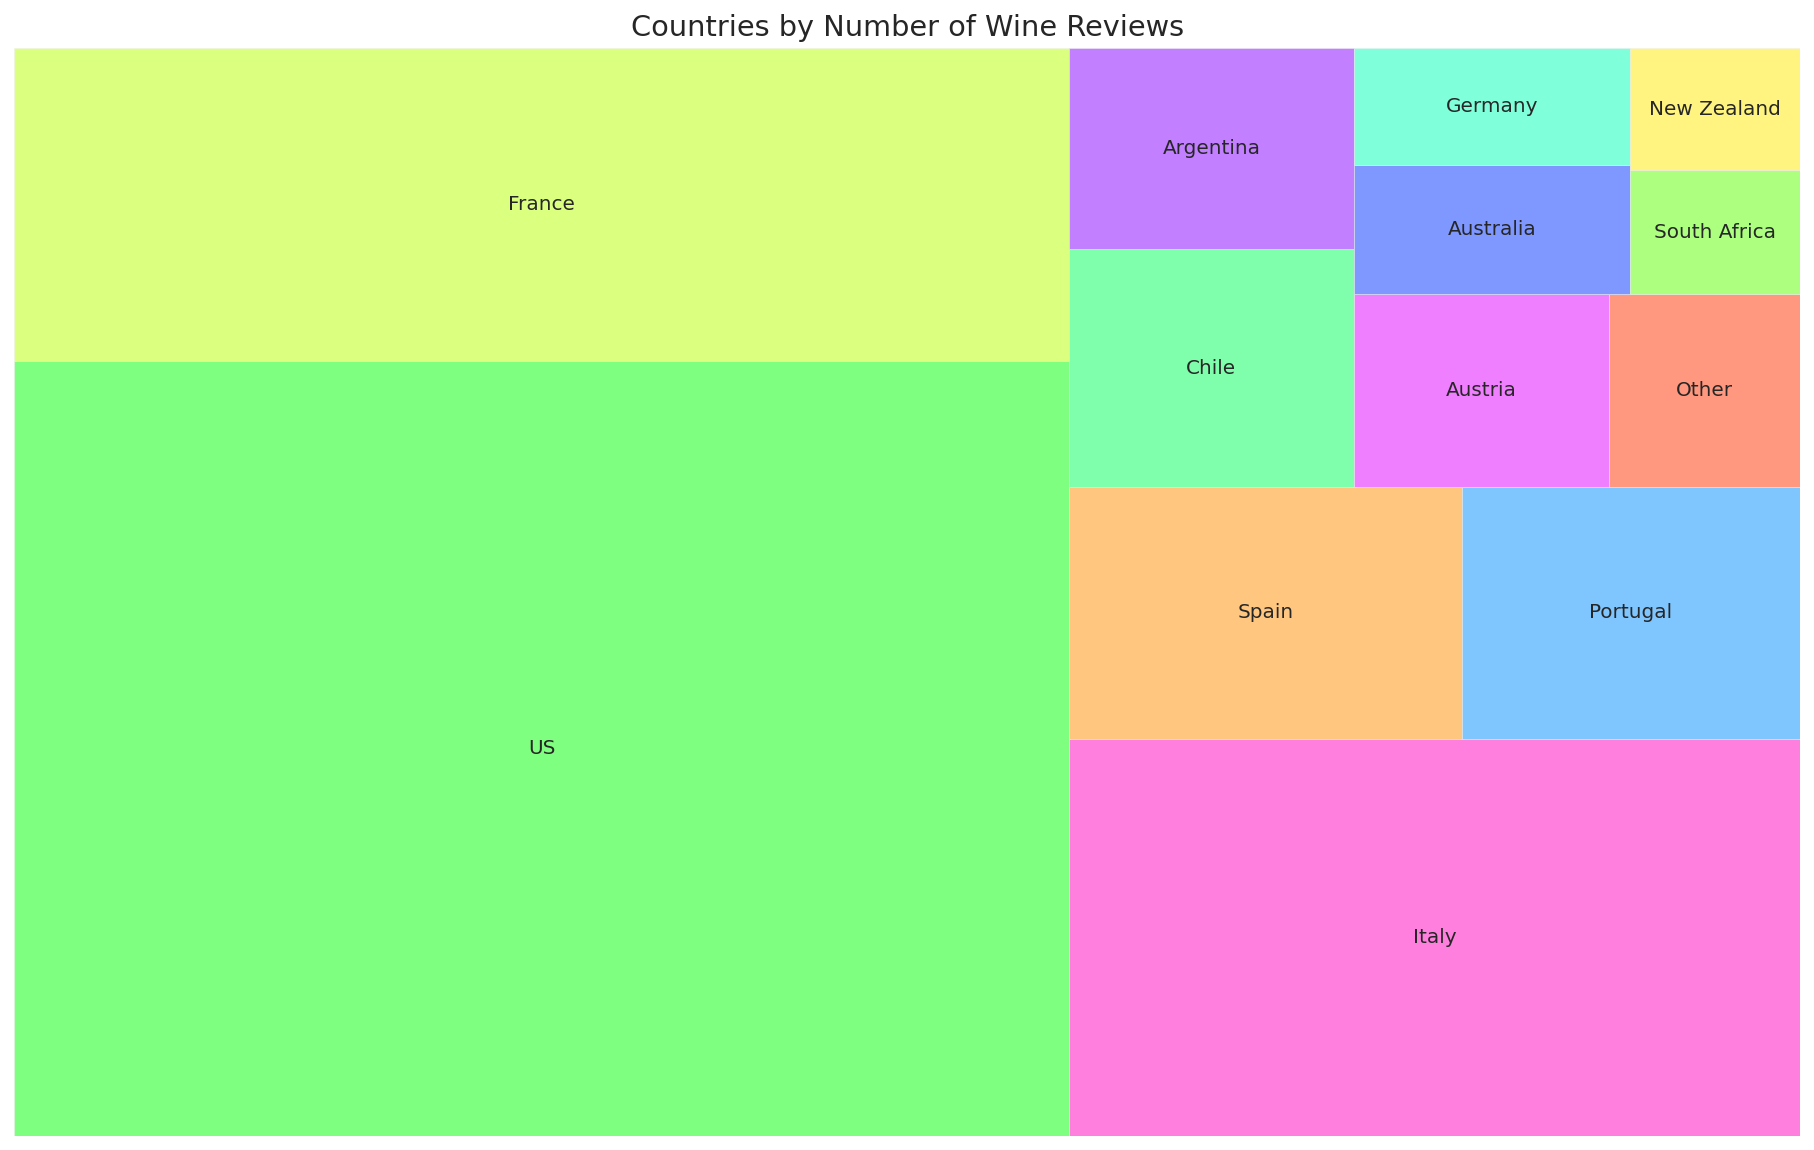

In [19]:
# Tree map 
cmap = plt.cm.gist_rainbow_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
colors = [cmap(norm(value)) for value in range(15)]
np.random.shuffle(colors)
fig,ax = plt.subplots(1,1,figsize=(16, 10))
sq.plot(sizes=less_countries.values, label=less_countries.index.values, alpha=0.5, ax=ax, color=colors)
plt.axis('off')
plt.title('Countries by Number of Wine Reviews')

The highest number of wine reviews is from the US

<a id="subsection-two"></a>
## 2.2 Price and Points

In [20]:
fig = iplot([go.Scatter(x=df.head(1000)['points'],
                  y=df.head(1000)['price'],
                  mode='markers', marker_color='darkred')])

In [21]:
data = df.assign(n=0).groupby(['points', 'price'])['n'].count().reset_index()
data = data[data["price"] < 100]
v = data.pivot(index='price', columns='points', values='n').fillna(0).values.tolist()
iplot([go.Surface(z=v)])

In [22]:
w = df.groupby(['country','points'])['price'].agg(['count','min','max','mean']).sort_values(by='mean',ascending=False)[:10]
w.reset_index(inplace=True)
w.style.background_gradient(cmap='Wistia', high=0.5)

Generally the more expensive the wine is the more points it gets

<a id="subsection-three"></a>
## 2.3 Variety of Wines

Number of variety of wines 707


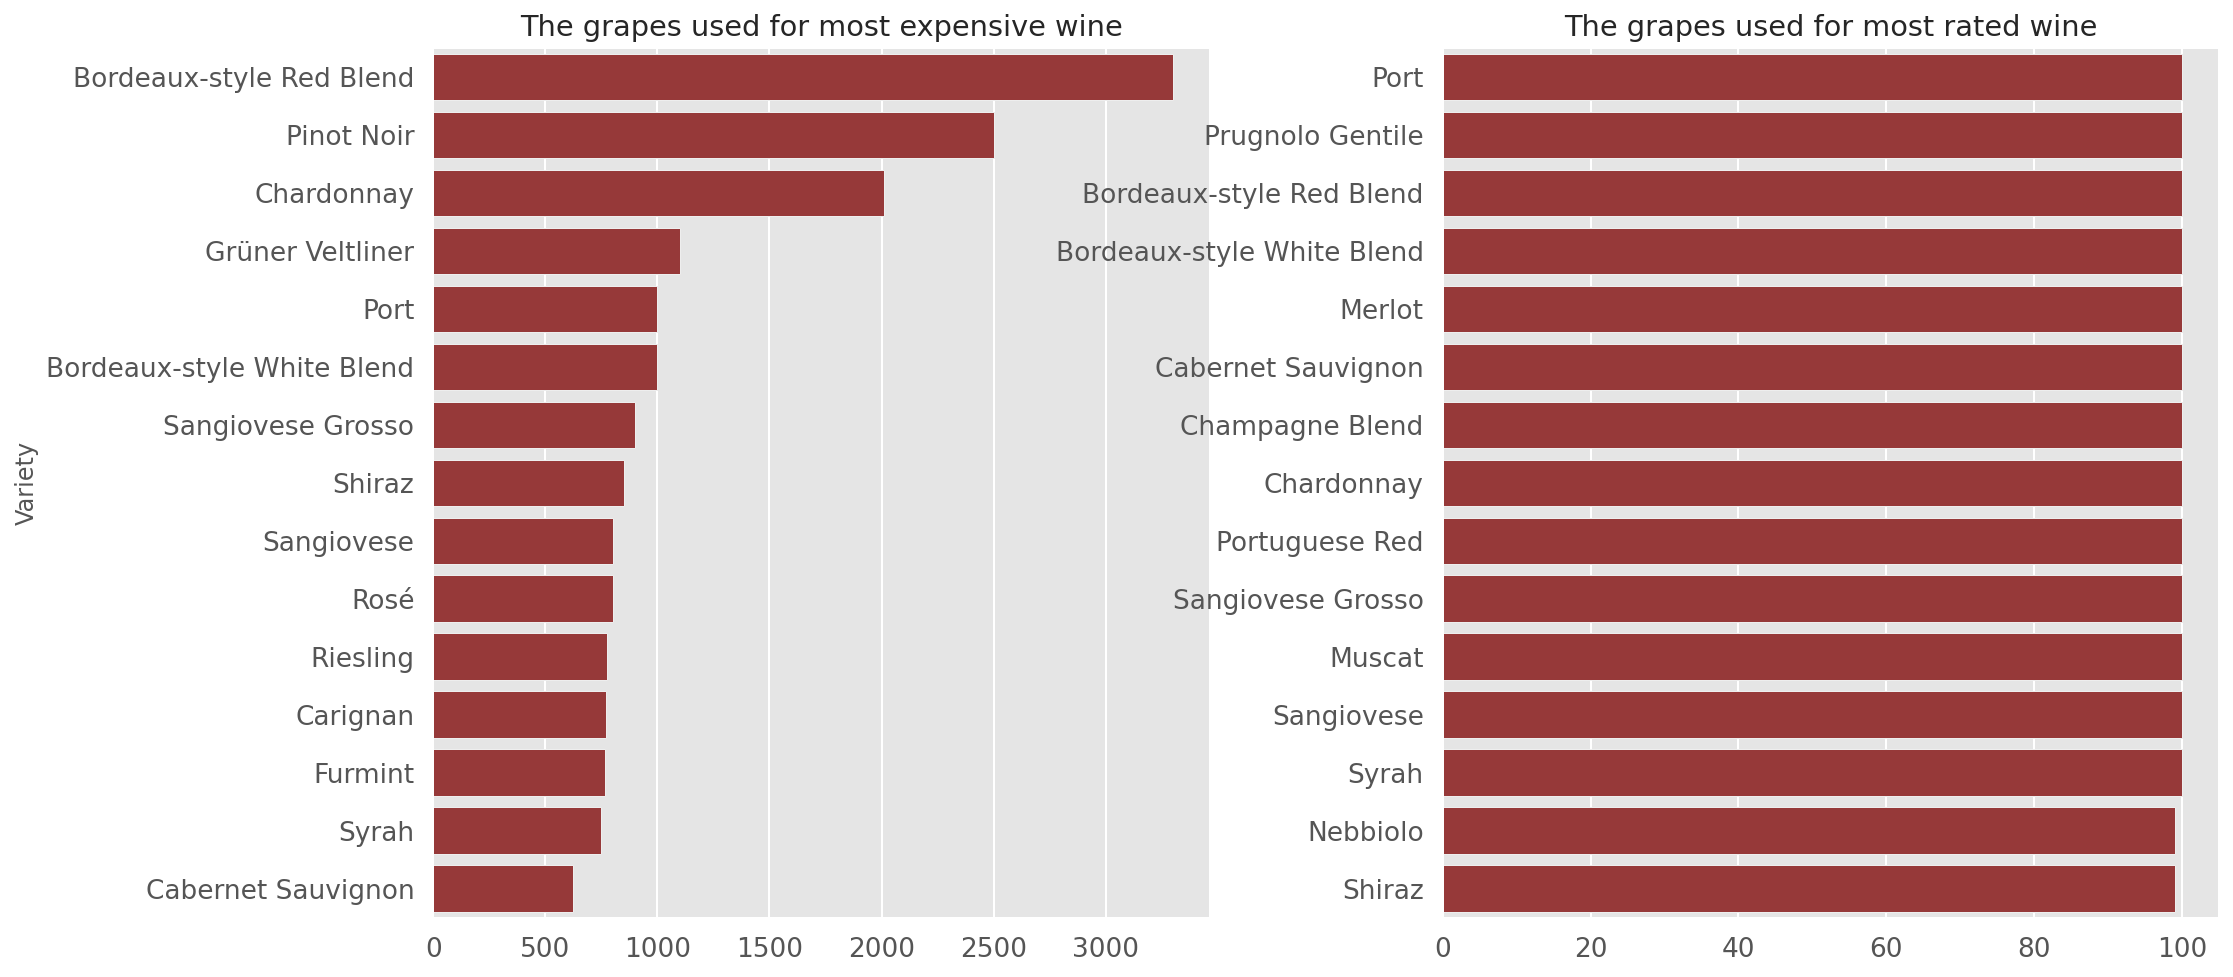

In [23]:
print(Fore.YELLOW + 'Number of variety of wines', df['variety'].nunique())
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='brown',ax=ax1)
ax1.set_title('The grapes used for most expensive wine')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['variety'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='brown',ax=ax2)
ax2.set_title('The grapes used for most rated wine')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

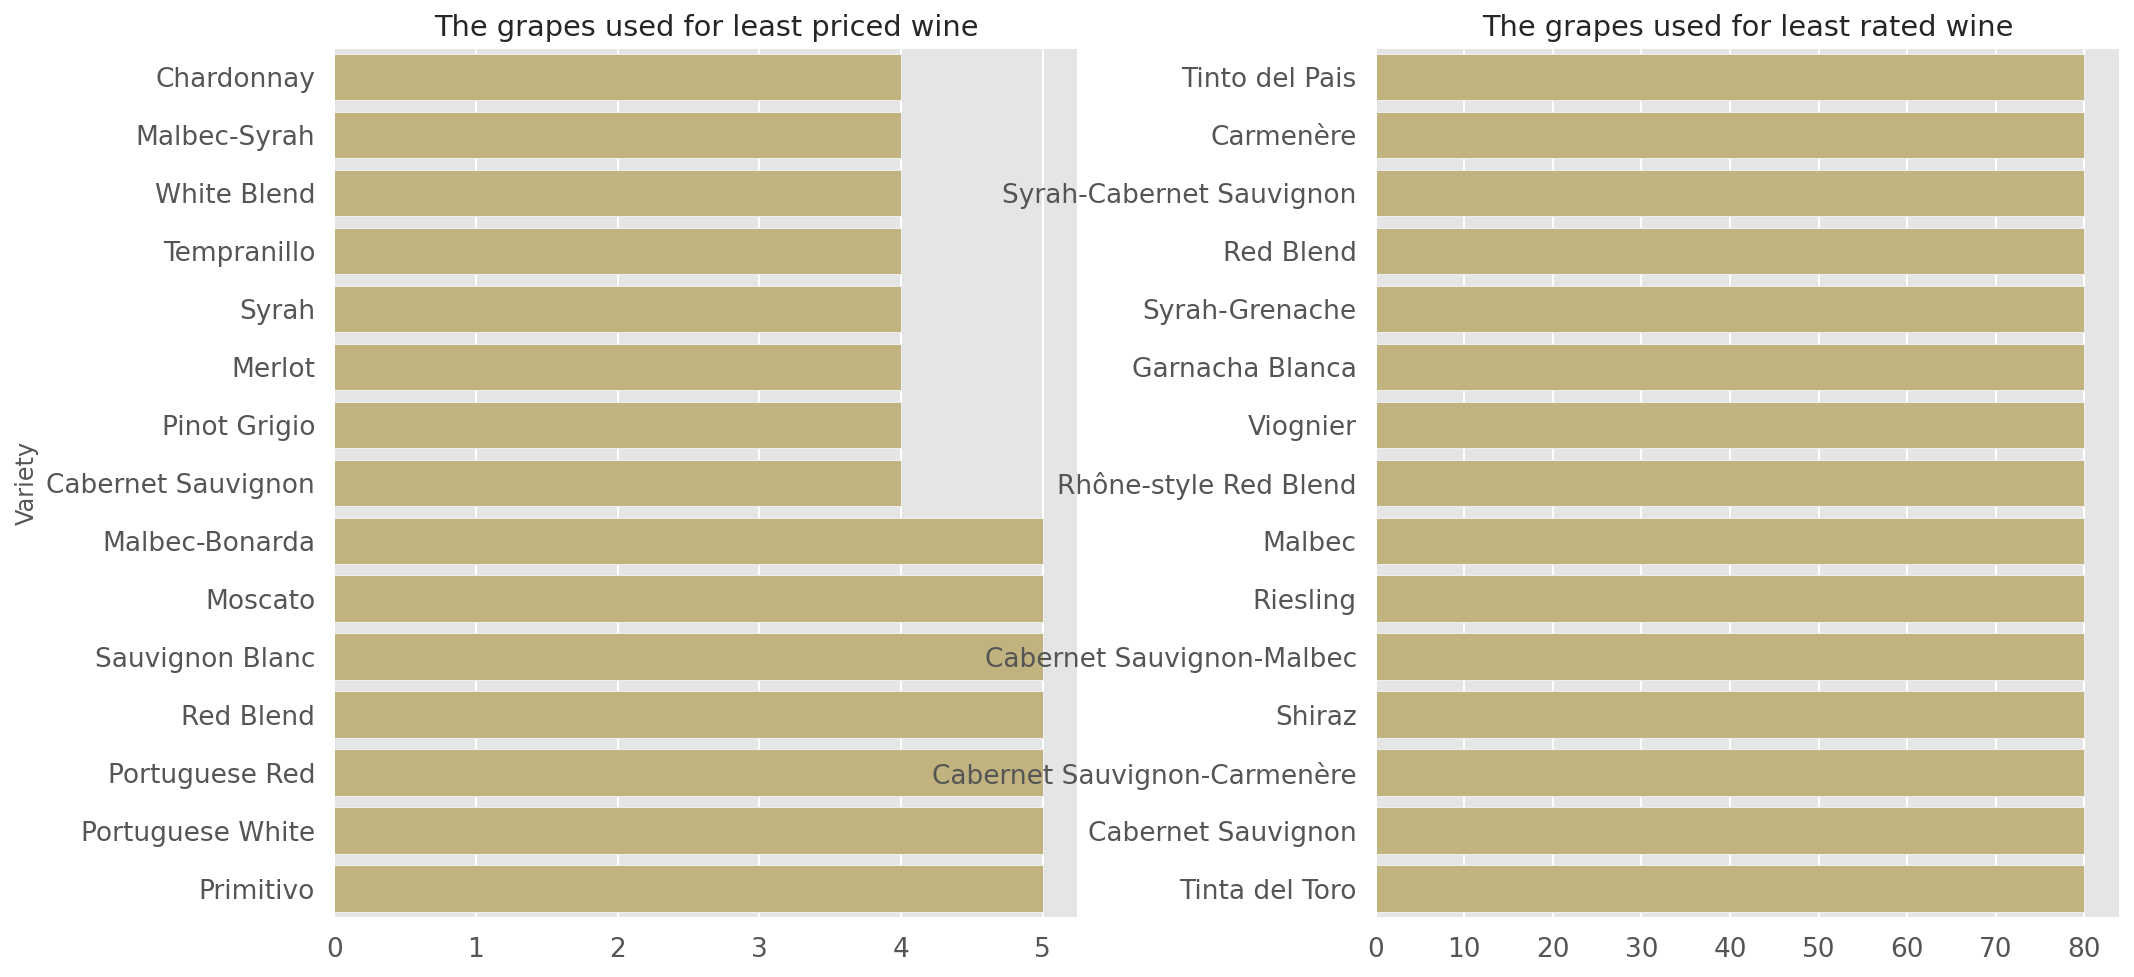

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='y',ax=ax1)
ax1.set_title('The grapes used for least priced wine')
ax1.set_xlabel('')
ax1.set_ylabel('Variety')
w = df.groupby(['variety'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='y', ax=ax2)
ax2.set_title('The grapes used for least rated wine')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.subplots_adjust(wspace=0.4);

There's a large variety of wines in the dataset. However, there's an exponential decline in the number of observations for each wine type, so we are going to use only wine types with high number of observations 

<a id="subsection-four"></a>
## 2.4 Wine Price by Country

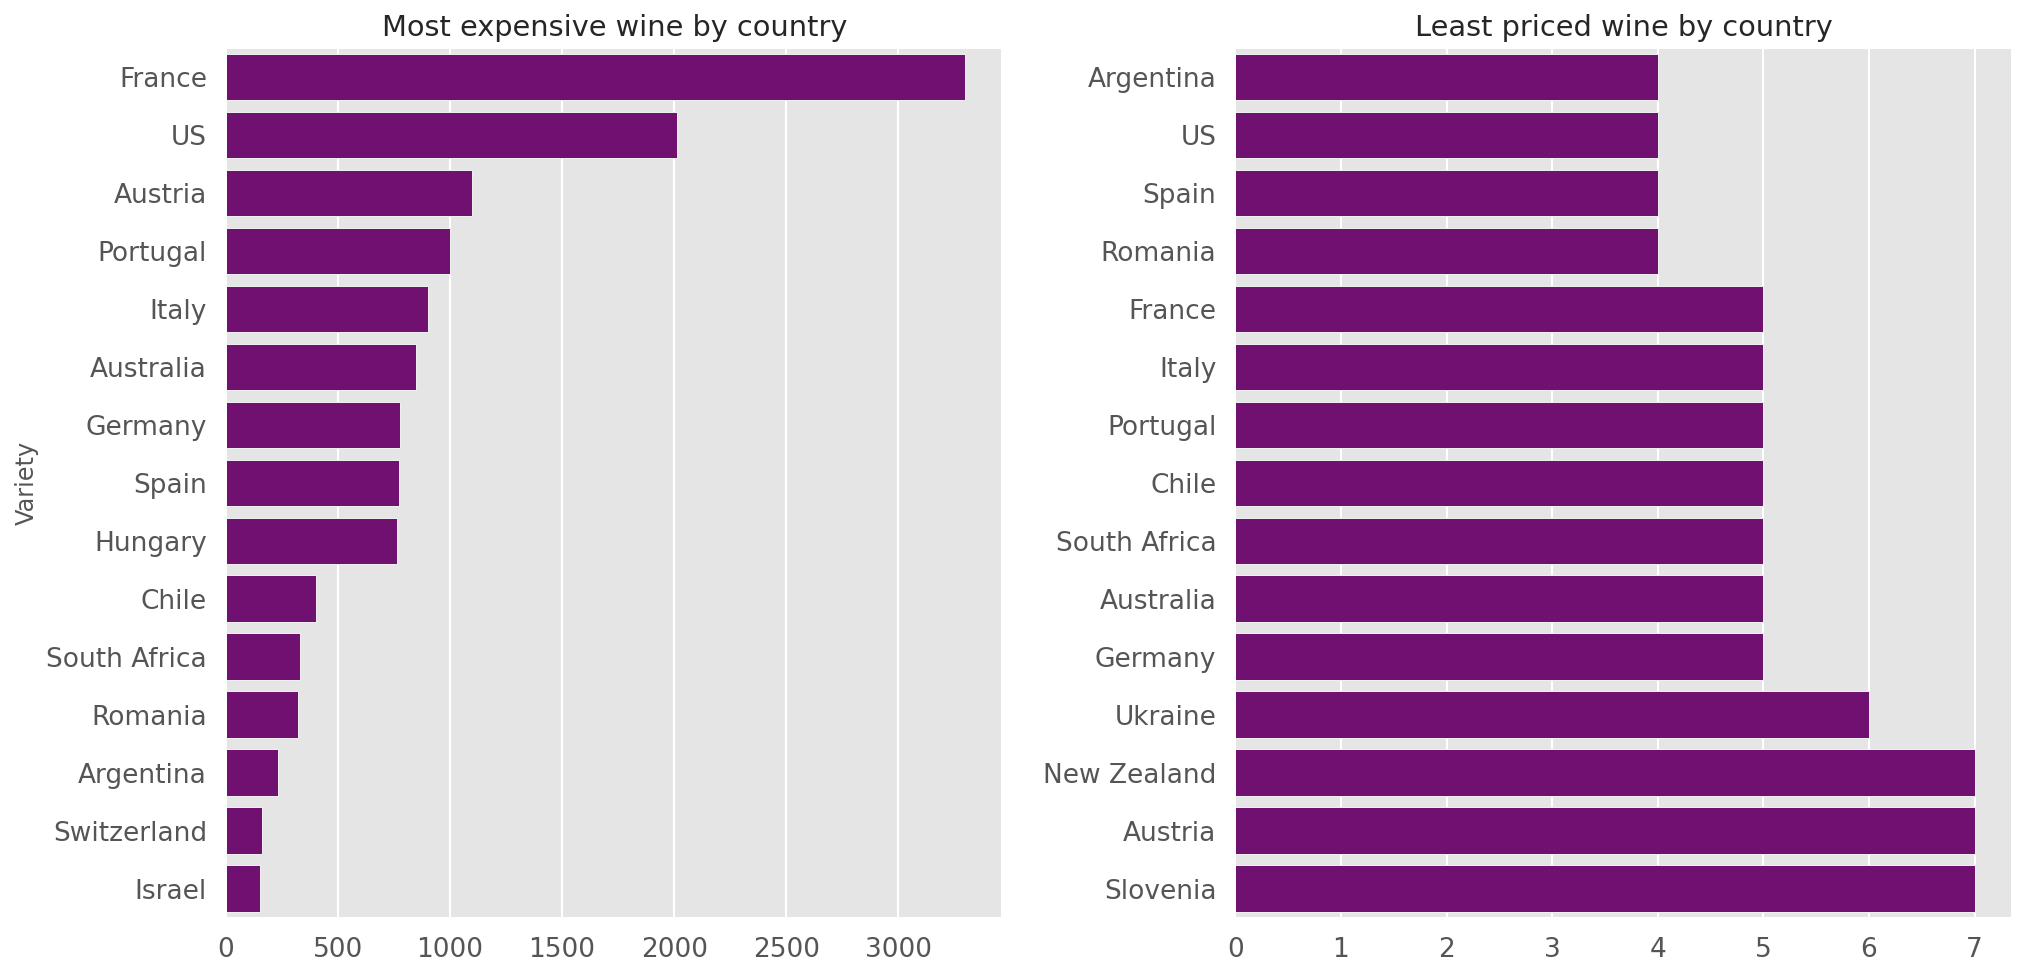

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='purple',ax=ax1)
ax1.set_title('Most expensive wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='purple',ax=ax2)
ax2.set_title('Least priced wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

France generally produces the most expensive wines while Argentina produces the cheapest wines

<a id="subsection-five"></a>
## 2.5 Highest and Least Rated Wines

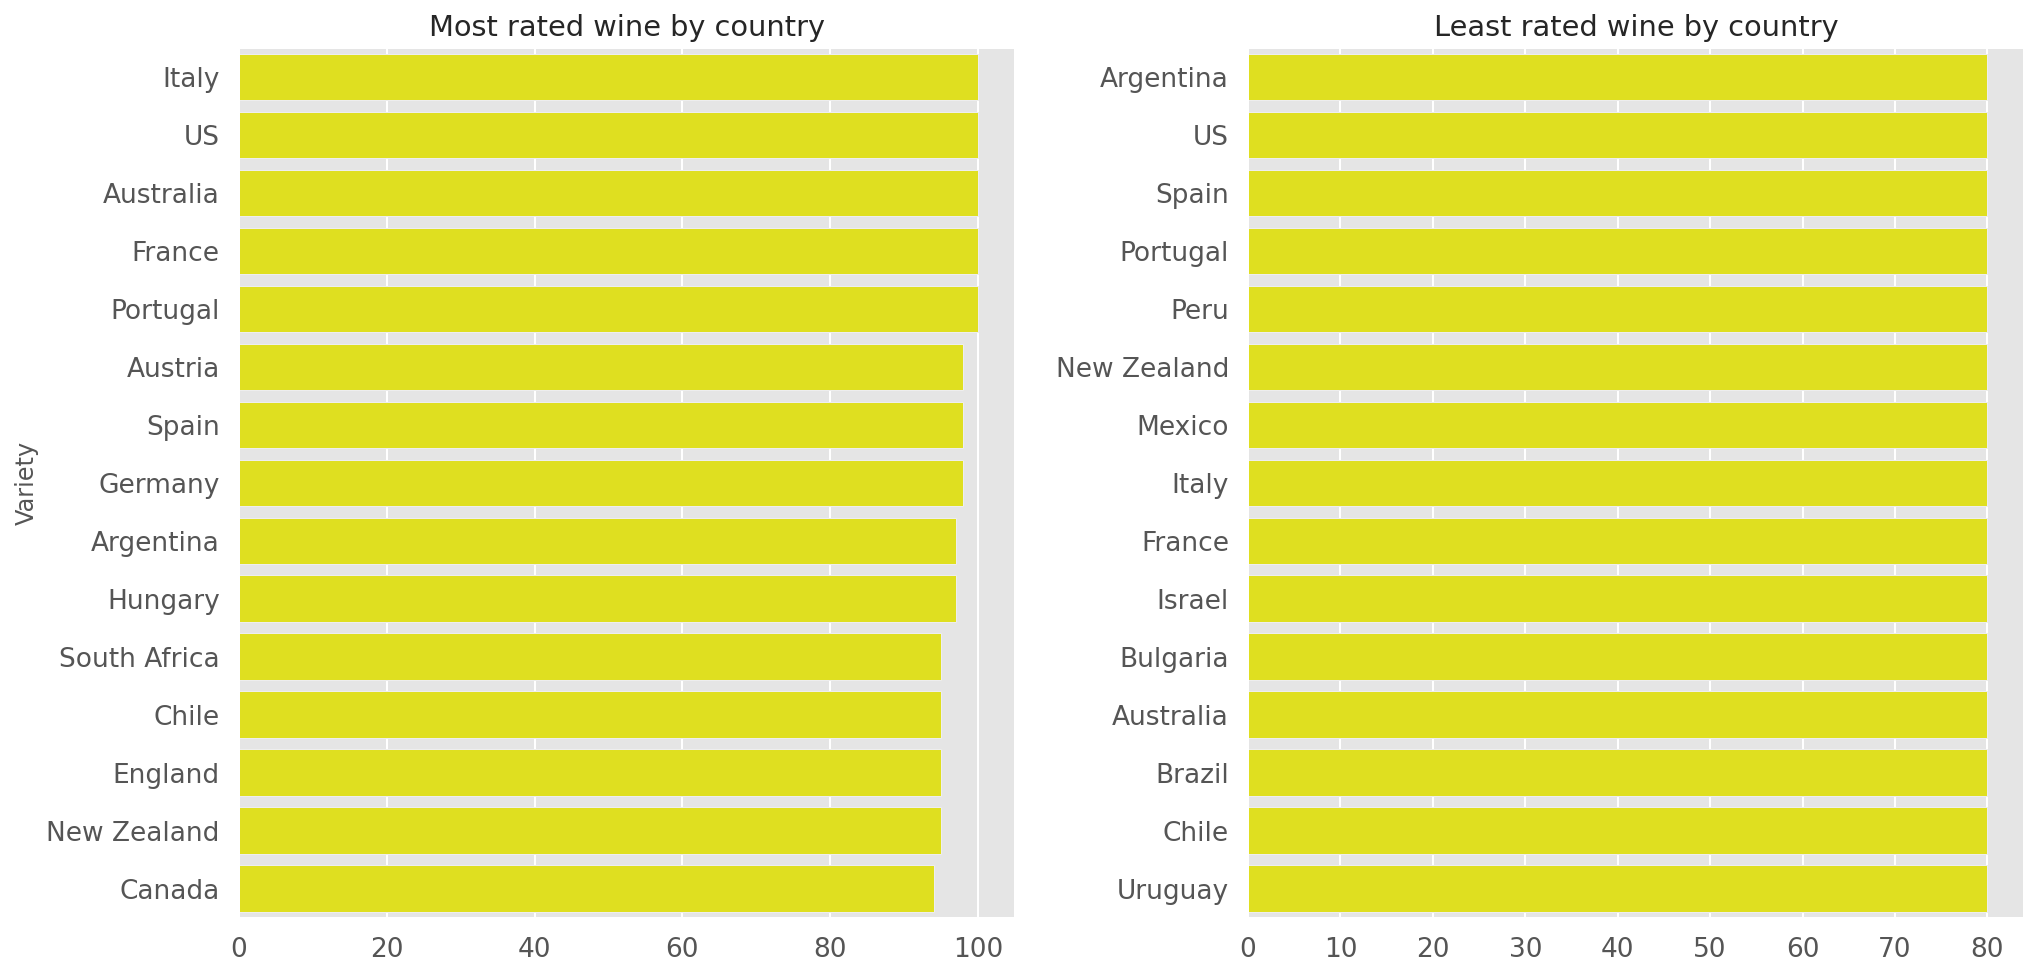

In [26]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='yellow',ax=ax1)
ax1.set_title('Most rated wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='yellow',ax=ax2)
ax2.set_title('Least rated wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

As we can see from the barplots the highest rated wines are from Italy and the least rated ones are from Argentina

<a id="subsection-six"></a>
## 2.6 Wine Reviews by Province

Number of province list in data: 425


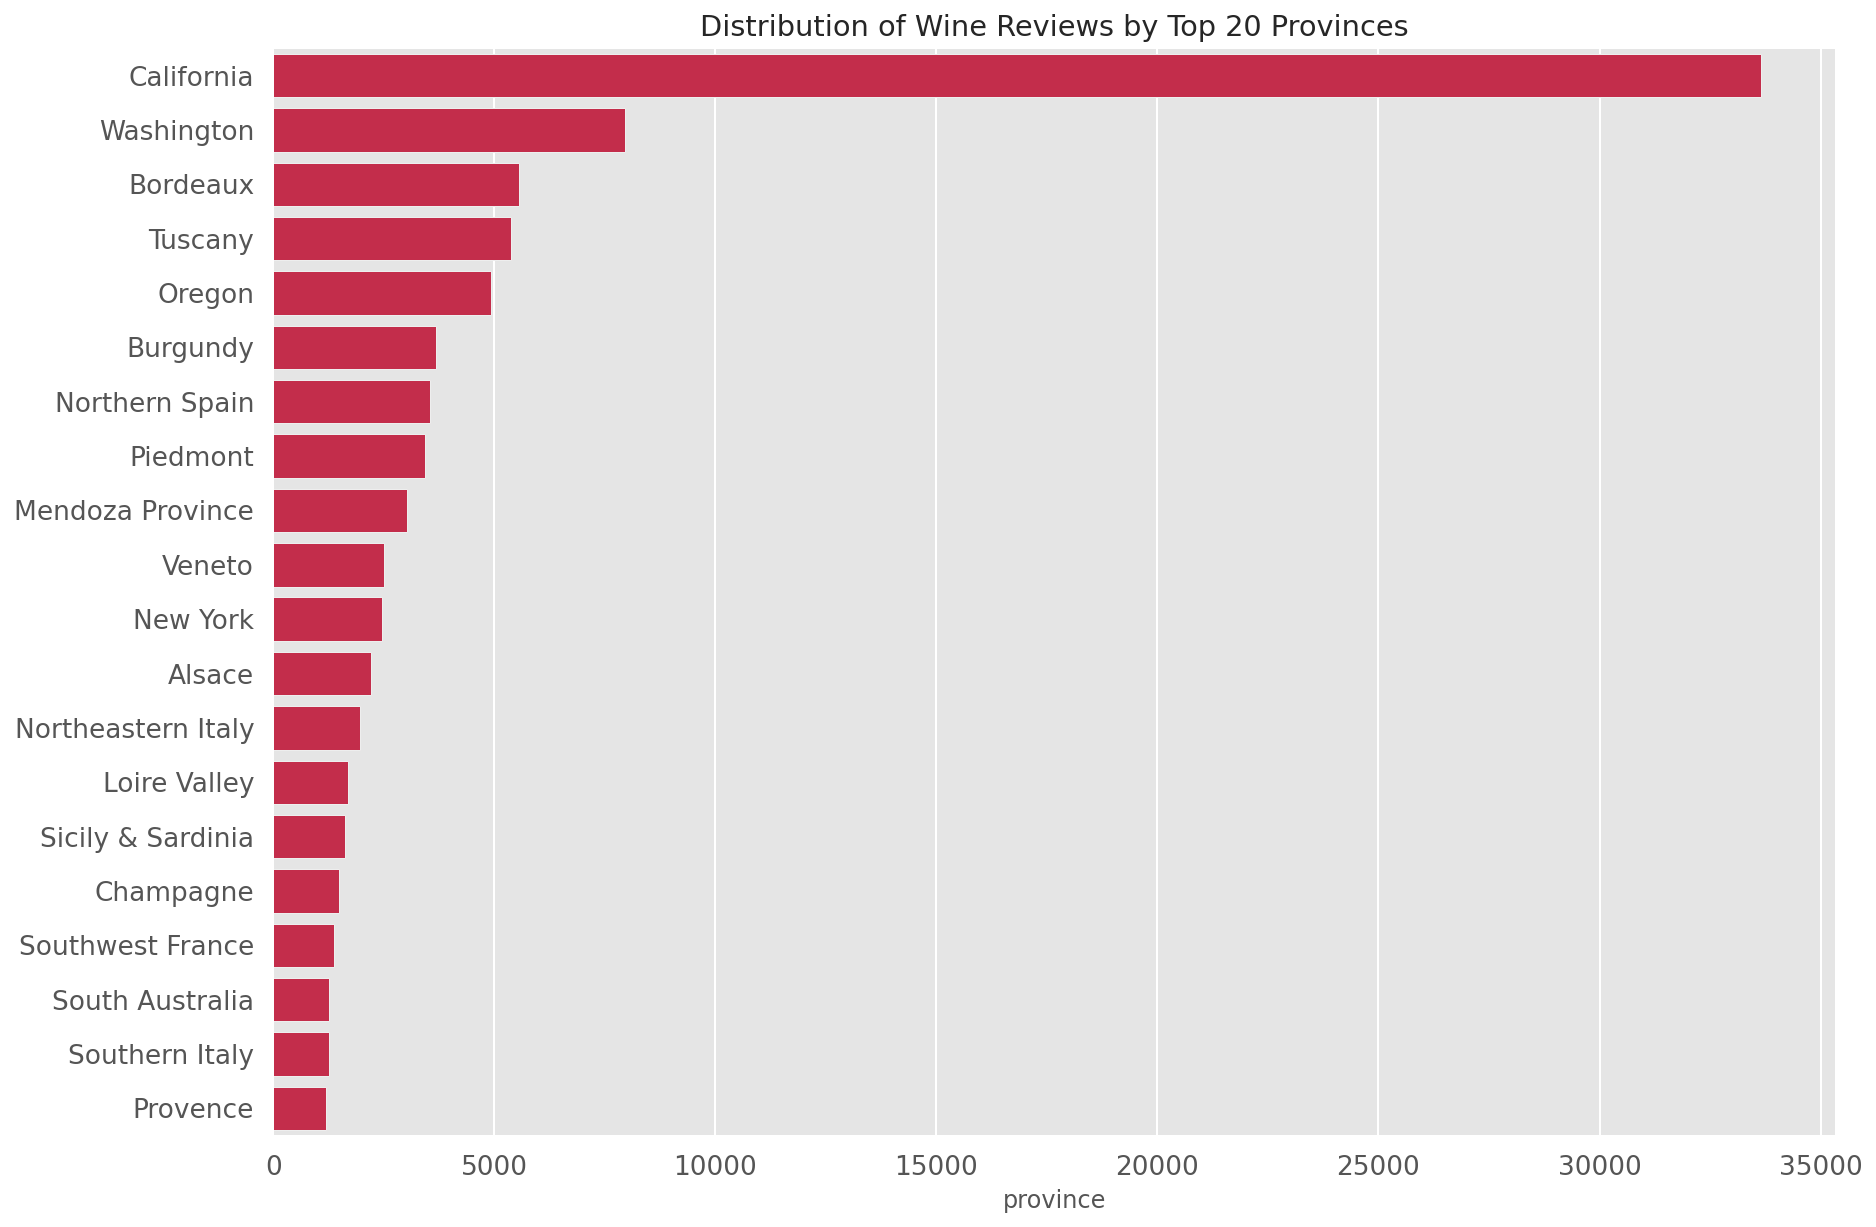

In [27]:
print(Fore.BLUE + Style.BRIGHT + 'Number of province list in data:', df['province'].nunique())
plt.figure(figsize=(14,10))
w = df['province'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= w['province'], y =w.index, data=w, color='crimson', orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Provinces');

California has the highest number of wine reviews, followed by Washington state 

<a id="subsection-seven"></a>
## 2.7 Vineyards and Wineries

Number of vineyard designation 37980


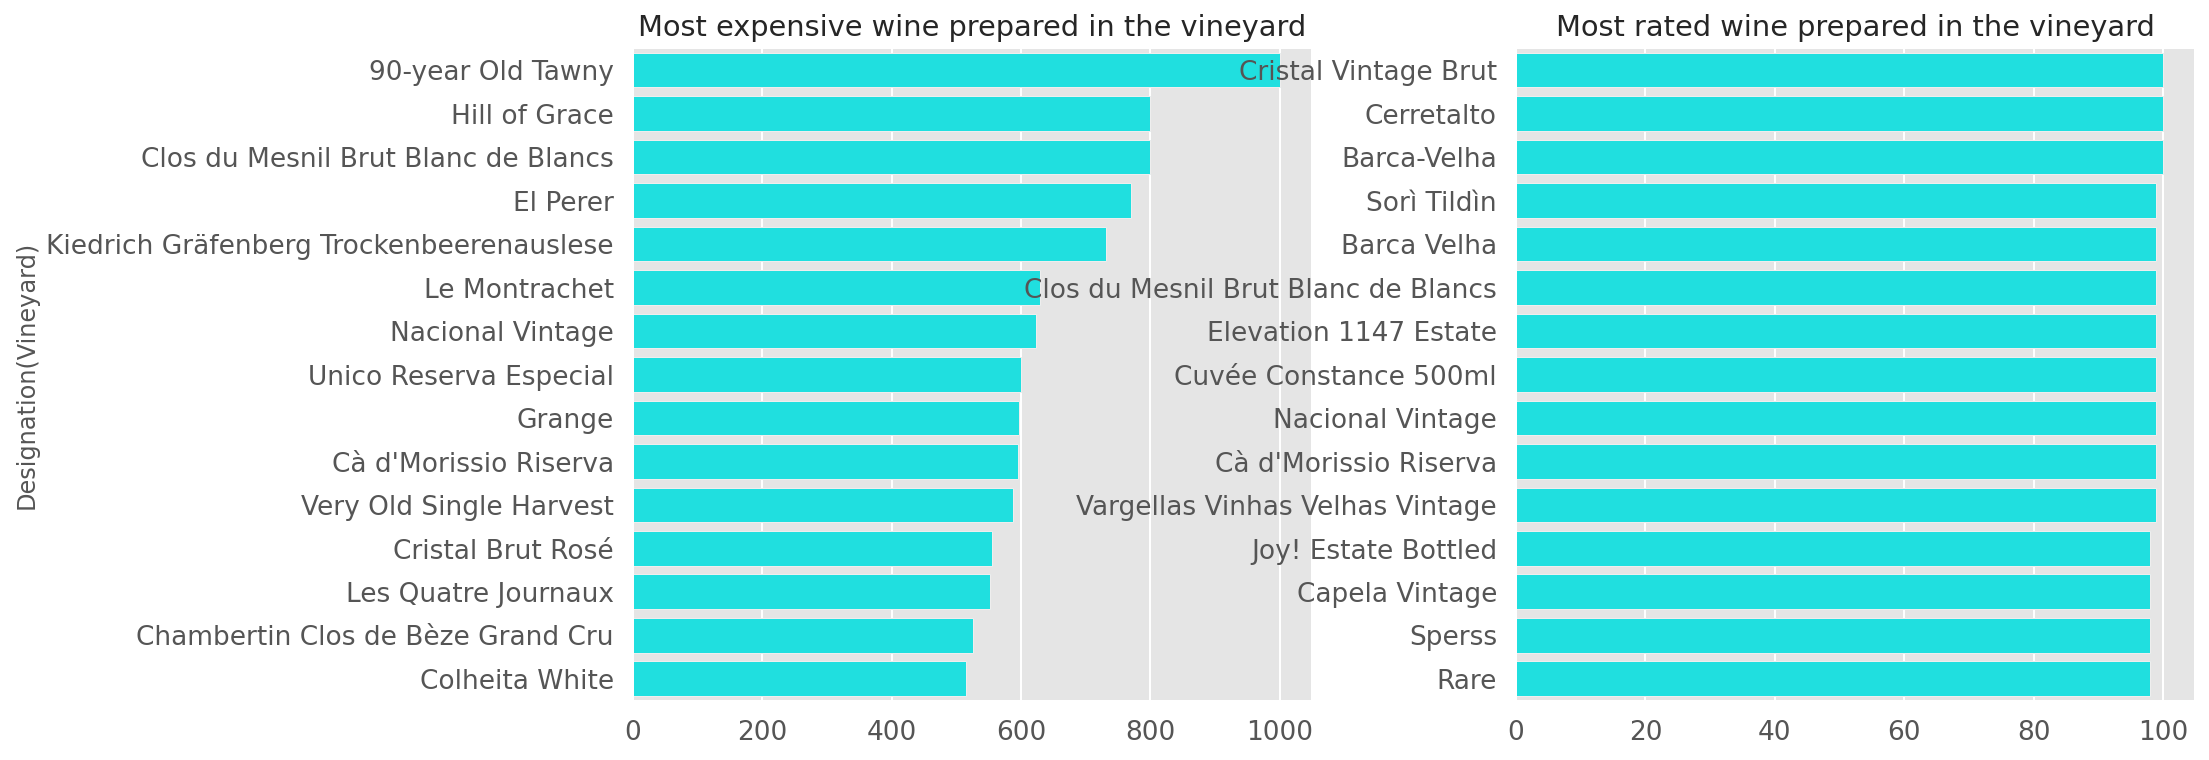

In [28]:
print(Fore.RED + Style.BRIGHT + 'Number of vineyard designation', df['designation'].nunique())
w = df.groupby(['designation'])['price'].mean().to_frame().sort_values(by='price',ascending=False)[:15]
f,ax = plt.subplots(1,2,figsize= (14,6))
ax1,ax2 = ax.flatten()
sns.barplot(w['price'], y = w.index, color='cyan', ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Designation(Vineyard)')
ax1.set_title('Most expensive wine prepared in the vineyard')
w = df.groupby(['designation'])['points'].mean().to_frame().sort_values(by = 'points', ascending = False)[:15]
sns.barplot(w['points'], y = w.index, color='cyan', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Most rated wine prepared in the vineyard')
plt.subplots_adjust(wspace=0.3)

Number of wineries: 16757


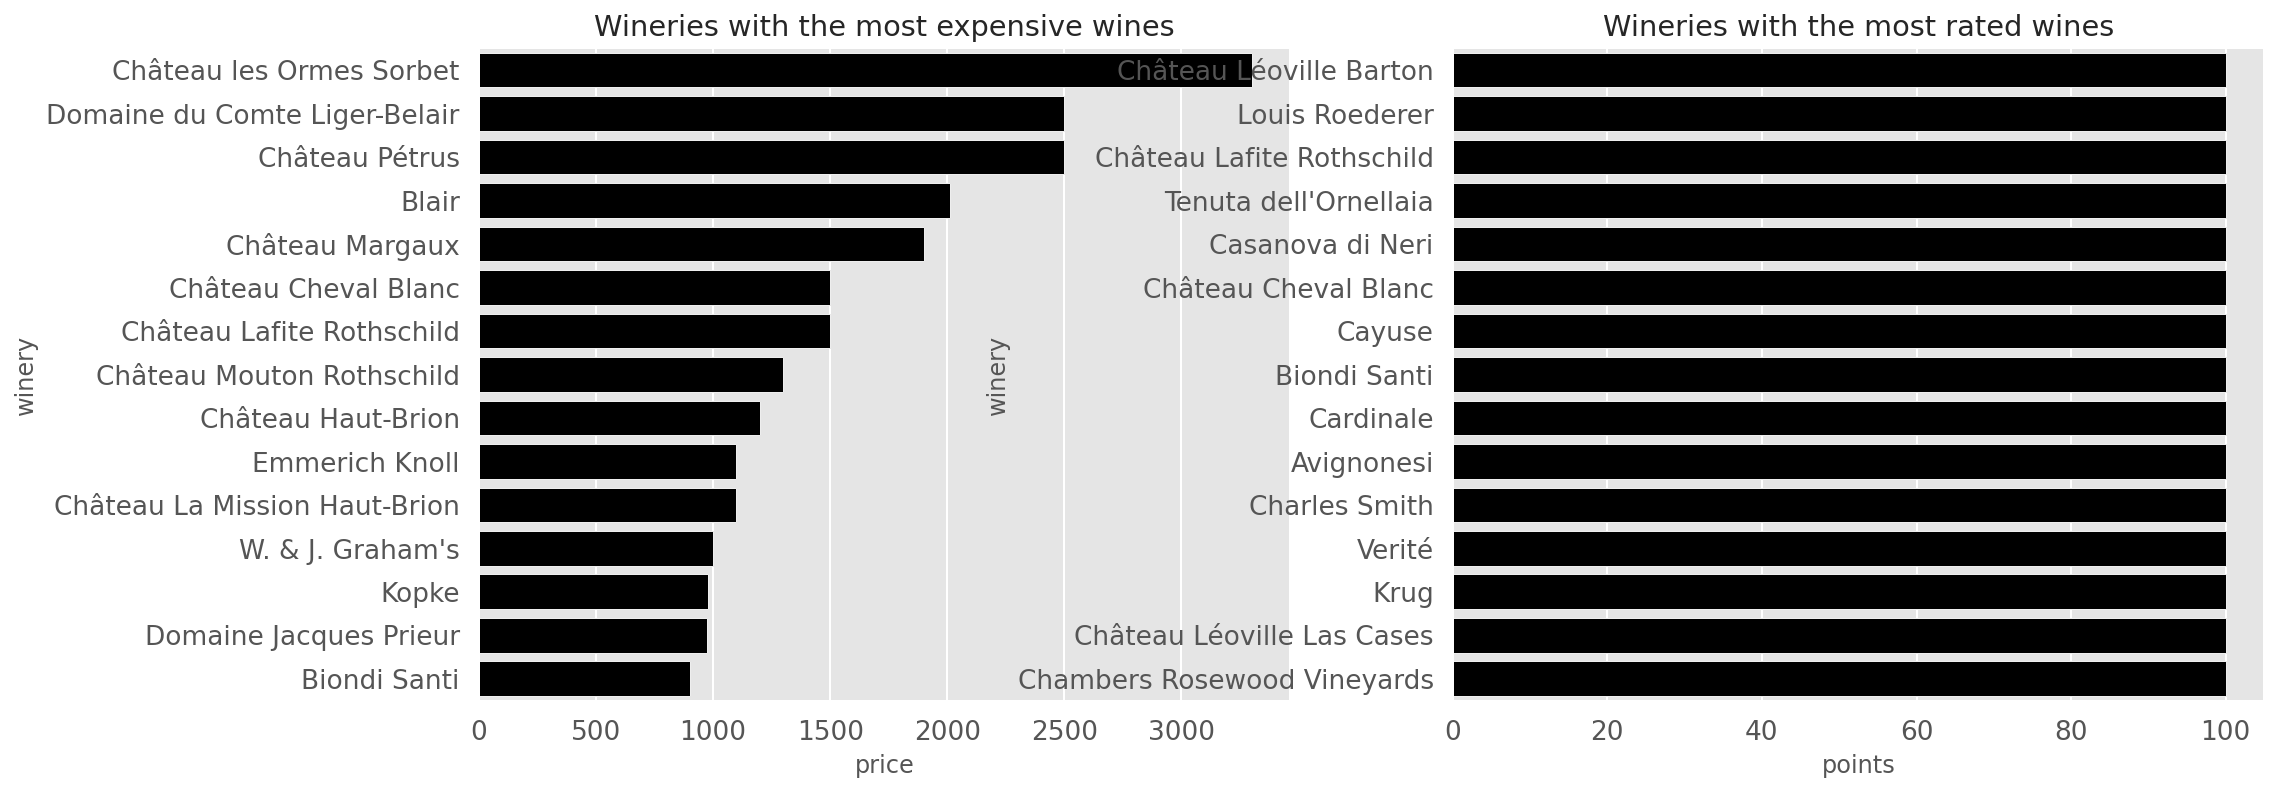

In [29]:
print(Fore.RED + Style.BRIGHT + 'Number of wineries:', df['winery'].nunique())
f,ax = plt.subplots(1,2,figsize=(16,6))
ax1,ax2 = ax.flatten()
w = df.groupby(['winery'])['price'].max().to_frame().sort_values(by='price',ascending=False)[:15]
sns.barplot(w['price'],y = w.index, color='black',ax = ax1)
ax1.set_title('Wineries with the most expensive wines')
w = df.groupby(['winery'])['points'].max().to_frame().sort_values(by = 'points', ascending = False)[:15]
sns.barplot(w['points'], y = w.index, color='black')
plt.title('Wineries with the most rated wines');

<a id="subsection-eight"></a>
## 2.8 Word Clouds

(-0.5, 999.5, 799.5, -0.5)

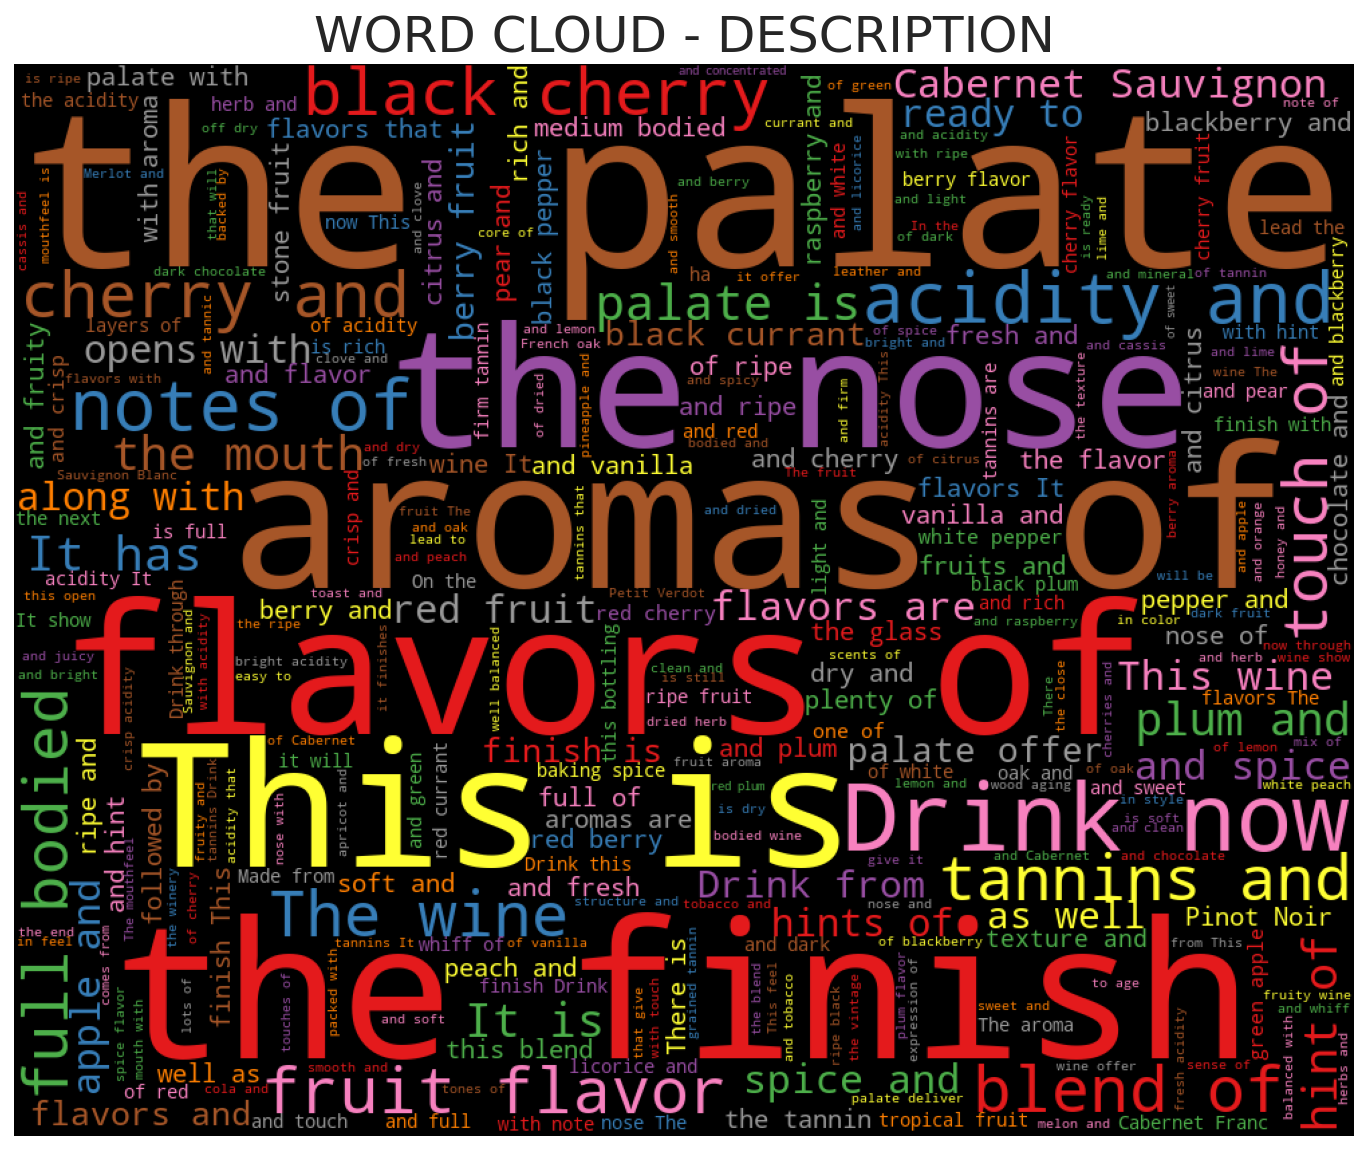

In [30]:
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "Drink", "black", 'wine', 'drink']
stopwords.update(newStopWords)
wordcloud = WordCloud(
    stopwords=stopwords,
    colormap='Set1',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['description'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION",fontsize=25)
plt.axis('off')

(-0.5, 999.5, 799.5, -0.5)

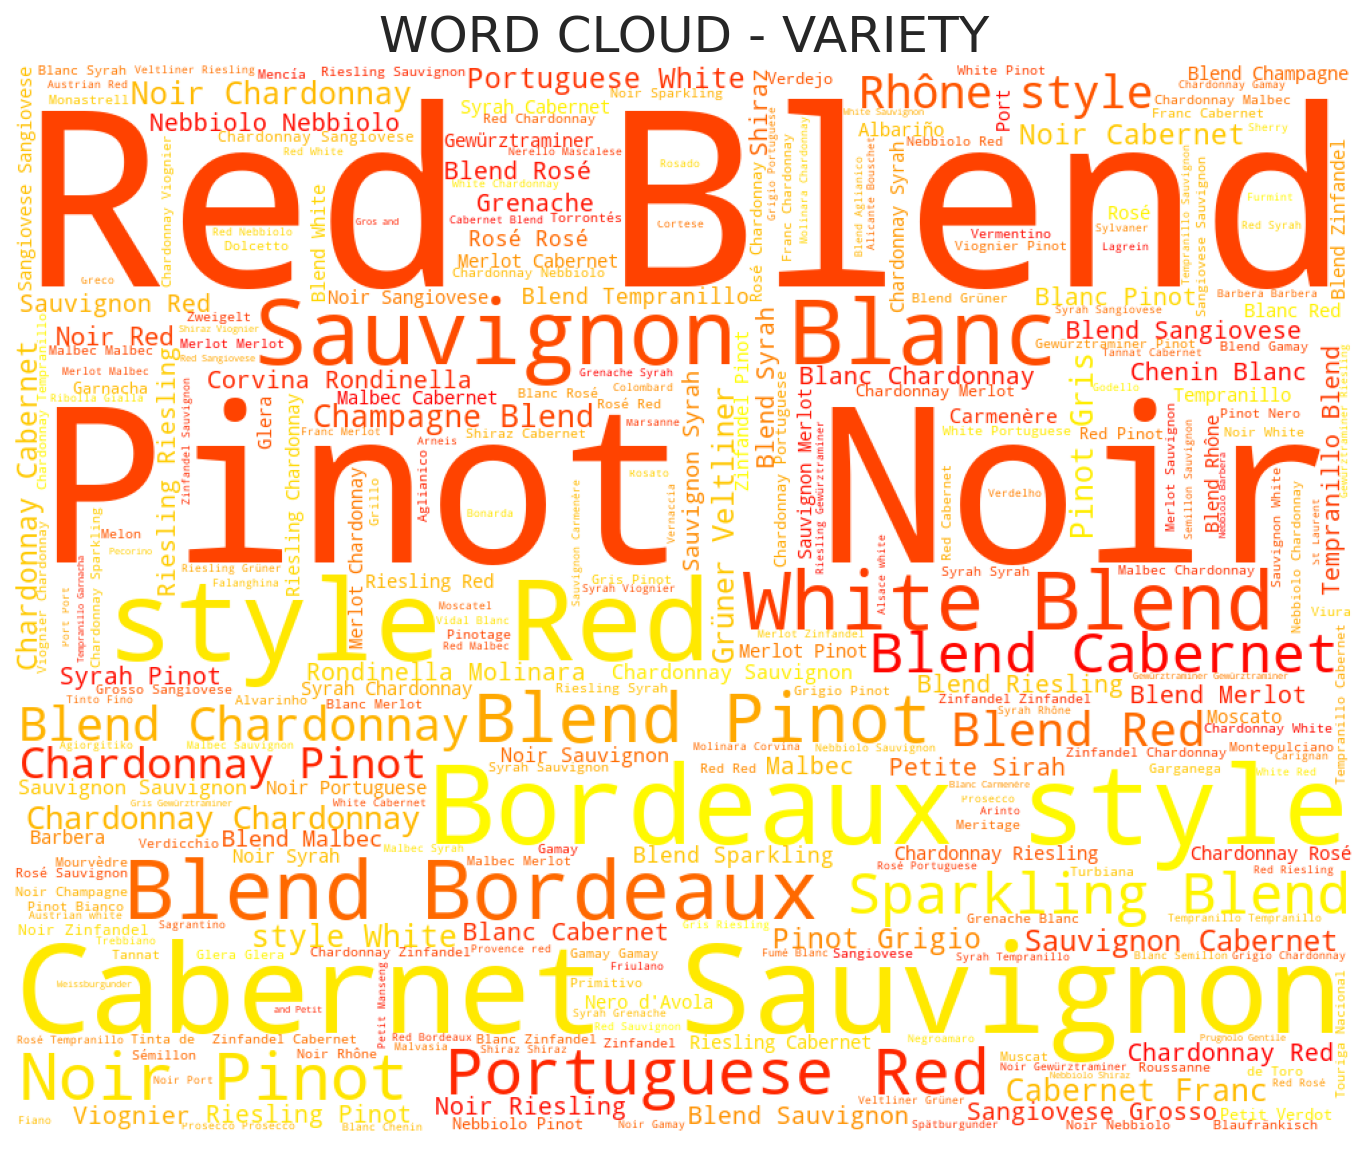

In [31]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    colormap='autumn_r',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['variety'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - VARIETY",fontsize=25)
plt.axis('off')

<a id="section-three"></a>
# 3. Preprocessing with SpaCy

**SpaCy** is a powerful and advanced library used for NLP tasks. Its main pros are speed, ease of use, accuracy and extensibility 

<a id="sub-one"></a>
## 3.1 Removing Code Syntax from Text and Using DisplaCy

In [32]:
!python -m spacy download en_core_web_lg
import spacy
nlp = spacy.load('en_core_web_lg')
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [33]:
# Removing code syntax from text 
df['description_Cleaned_1'] = df['description'].apply(normalize_text)

In [34]:
print(Fore.MAGENTA + 'Before normalizing text-----\n')
print(df['description'])
print(Fore.YELLOW + Style.DIM + '\nAfter normalizing text-----\n')
print(df['description_Cleaned_1'])

Before normalizing text-----

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 119988, dtype: object

After normalizing text-----

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blo


SpaCy comes with a built-in visualizer called **DisplaCy**

In [35]:
from spacy import displacy
about_interest_text = ('I like different types of wine')
about_interest_doc = nlp(about_interest_text)
displacy.render(about_interest_doc, style='dep')

<a id="sub-two"></a>
## 3.2 Stop Words and Lemmatization

**Stop words** are the most common words in a language

In [36]:
# Stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
len(spacy_stopwords)
for stop_word in list(spacy_stopwords)[:10]:
    print(Fore.CYAN + stop_word)

she
noone
put
nevertheless
everyone
back
n‘t
had
they
next


We defined some stop words, but we won't remove them. Stop words can contain useful information, and discarding them is not always helpful

**Lemmatization** is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a **lemma**

In [37]:
doc = nlp(df["description"][3])

In [38]:
review = str(" ".join([i.lemma_ for i in doc]))

In [39]:
doc = nlp(review)
spacy.displacy.render(doc, style='ent', jupyter=True)

<a id="sub-three"></a>
## 3.3 Part of Speech Tagging (POS)

**Part of speech** or **POS** is a grammatical role that explains how a particular word is used in a sentence. There are eight parts of speech: noun, pronoun, adjective, verb, adverb, preposition, conjunction, interjection. **Part of speech tagging** is the process of assigning a POS tag to each token depending on its usage in the sentence. POS tags are useful for assigning a syntactic category like noun or verb to each word. In spaCy, POS tags are available as an attribute on the Token object:

In [40]:
# Part of Speech Tagging
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
punctuations = string.punctuation
stopwords = STOP_WORDS

In [41]:
# POS tagging
for i in nlp(review):
    print(i, Fore.GREEN + "=>",i.pos_)

pineapple => NOUN
rind => NOUN
, => PUNCT
lemon => NOUN
pith => NOUN
and => CCONJ
orange => NOUN
blossom => NOUN
start => VERB
off => ADP
the => DET
aroma => NOUN
. => PUNCT
the => DET
palate => NOUN
be => AUX
a => DET
bit => NOUN
more => ADV
opulent => ADJ
, => PUNCT
with => ADP
note => NOUN
of => ADP
honey => NOUN
- => PUNCT
drizzle => NOUN
guava => NOUN
and => CCONJ
mango => NOUN
give => VERB
way => NOUN
to => ADP
a => DET
slightly => ADV
astringent => ADJ
, => PUNCT
semidry => PROPN
finish => NOUN
. => PUNCT


In [42]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [43]:
tqdm.pandas()
df["processed_description"] = df["description"].progress_apply(spacy_tokenizer)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|██████████| 119988/119988 [00:45<00:00, 2614.88it/s]


<a id="sub-four"></a>
## 3.4 Topic Modeling

**Topic Modeling** is the process of extracting the main topics from a collection of text data or documents. Essentially, it's a form of Dimensionality Reduction

In [44]:
# Topic Modeling
# Creating a vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["processed_description"])

In [45]:
NUM_TOPICS = 10

In [46]:
# Latent Dirichlet Allocation Model
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [47]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized)

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [48]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [49]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [50]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print(Back.RED + "LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('apple', 12374.92781754517), ('palate', 11769.329844364185), ('finish', 10301.482043374586), ('citrus', 9256.200953697757), ('flavors', 9226.564452922763), ('lemon', 8709.355152343735), ('white', 8478.054450966278), ('peach', 7556.670452262894), ('aromas', 7440.828307172521), ('pear', 7081.9440492903195)]
Topic 1:
[('wine', 33173.02156535094), ('acidity', 16412.34353158719), ('drink', 15774.584436051022), ('ripe', 13222.53614482357), ('fruits', 11753.338840208738), ('fruit', 9412.970710771224), ('flavors', 7726.852185302843), ('red', 7635.629648368986), ('character', 7617.332543453811), ('fruity', 6765.643249658265)]
Topic 2:
[('nose', 4771.532058322743), ('bottling', 3354.189570275877), ('palate', 2180.770913029961), ('dried', 1436.3133675245006), ('based', 1392.801418006022), ('tightly', 1377.1047546360553), ('heavy', 1230.803629458454), ('shows', 1180.4275803682192), ('extra', 1126.999422624822), ('dominate', 1067.3623521600748)]
Topic 3:
[('cherry', 14108.6329

In [51]:
# Keywords for topics clustered by Latent Semantic Indexing
print(Back.BLUE + "NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('flavors', 18.639790333299594), ('aromas', 2.565031804128244), ('sweet', 2.0093286879566077), ('dry', 1.850909950269701), ('oak', 1.4856484230282319), ('good', 1.346879677871494), ('vanilla', 1.1786165957218553), ('blackberry', 1.12420045972658), ('like', 1.0034871048770706), ('rich', 0.769384327159966)]
Topic 1:
[('wine', 14.96628137139732), ('fruits', 0.870683357387228), ('texture', 0.8453425656873117), ('rich', 0.790550818034729), ('character', 0.7775233885501903), ('wood', 0.6221512820118598), ('aging', 0.5799757007117058), ('age', 0.5606829504307868), ('structure', 0.5392058750126434), ('bodied', 0.4807088813942466)]
Topic 2:
[('black', 11.107740228114912), ('tannins', 3.8025153240233767), ('cherry', 2.1209653427079576), ('pepper', 2.0174352866260086), ('dark', 1.9091207159932446), ('plum', 1.611091931861381), ('blackberry', 1.3008508215471528), ('licorice', 1.0612177639808476), ('currant', 1.0562835094166692), ('firm', 1.0385802588736788)]
Topic 3:
[('palate

In [52]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print(Back.MAGENTA + "LSI Model:")
selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('wine', 0.4676857441216025), ('flavors', 0.33722295803186925), ('fruit', 0.27635720886578896), ('aromas', 0.21235566104186182), ('palate', 0.19869544736969957), ('acidity', 0.18564224864209106), ('tannins', 0.17921207462270086), ('finish', 0.17819852636234632), ('black', 0.17480465031177564), ('drink', 0.1712828357876428)]
Topic 1:
[('wine', 0.6748810261345022), ('drink', 0.11588475110588659), ('acidity', 0.112384782133878), ('fruits', 0.10601829487880195), ('rich', 0.08609057273611524), ('ripe', 0.07539352850701946), ('character', 0.06169870182543058), ('texture', 0.06075973695740941), ('fruity', 0.056295912456316544), ('aging', 0.05217720625228234)]
Topic 2:
[('black', 0.44230926743128546), ('tannins', 0.36173225280551874), ('cherry', 0.2710774358102783), ('dark', 0.11077554169824404), ('red', 0.0991937442702963), ('firm', 0.09552309177030455), ('cabernet', 0.09407556674419072), ('pepper', 0.08470331468574148), ('drink', 0.08305625811513632), ('spice', 0.0804105

In [53]:
# Transforming an individual sentence
text = spacy_tokenizer("Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.")
x = lda.transform(vectorizer.transform([text]))[0]
print(x)

[0.68829739 0.00500035 0.00500071 0.27169931 0.00500078 0.00500048
 0.00500005 0.00500017 0.00500062 0.00500015]


<a id="section-four"></a>
# 4. Preparing Data for the Model

In [54]:
# Description and variety of grapes
df = df[['description', 'variety']]
df.head()

description         variety
0  Aromas include tropical fruit, broom, brimston...     White Blend
1  This is ripe and fruity, a wine that is smooth...  Portuguese Red
2  Tart and snappy, the flavors of lime flesh and...      Pinot Gris
3  Pineapple rind, lemon pith and orange blossom ...        Riesling
4  Much like the regular bottling from 2012, this...      Pinot Noir

In [55]:
# Getting top 8 most described variety
temp_df = df.variety.value_counts()
temp_df.head(8)

Pinot Noir                  12278
Chardonnay                  10868
Cabernet Sauvignon           8840
Red Blend                    8243
Bordeaux-style Red Blend     6471
Riesling                     4773
Sauvignon Blanc              4575
Syrah                        3828
Name: variety, dtype: int64

In [56]:
# For this project we are taking top 8 variety only
mask = df['variety'].isin(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
                           'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc',
                           'Syrah'])
df = df[mask]
df.head()

description             variety
3   Pineapple rind, lemon pith and orange blossom ...            Riesling
4   Much like the regular bottling from 2012, this...          Pinot Noir
10  Soft, supple plum envelopes an oaky structure ...  Cabernet Sauvignon
12  Slightly reduced, this wine offers a chalky, t...  Cabernet Sauvignon
14  Building on 150 years and six generations of w...          Chardonnay

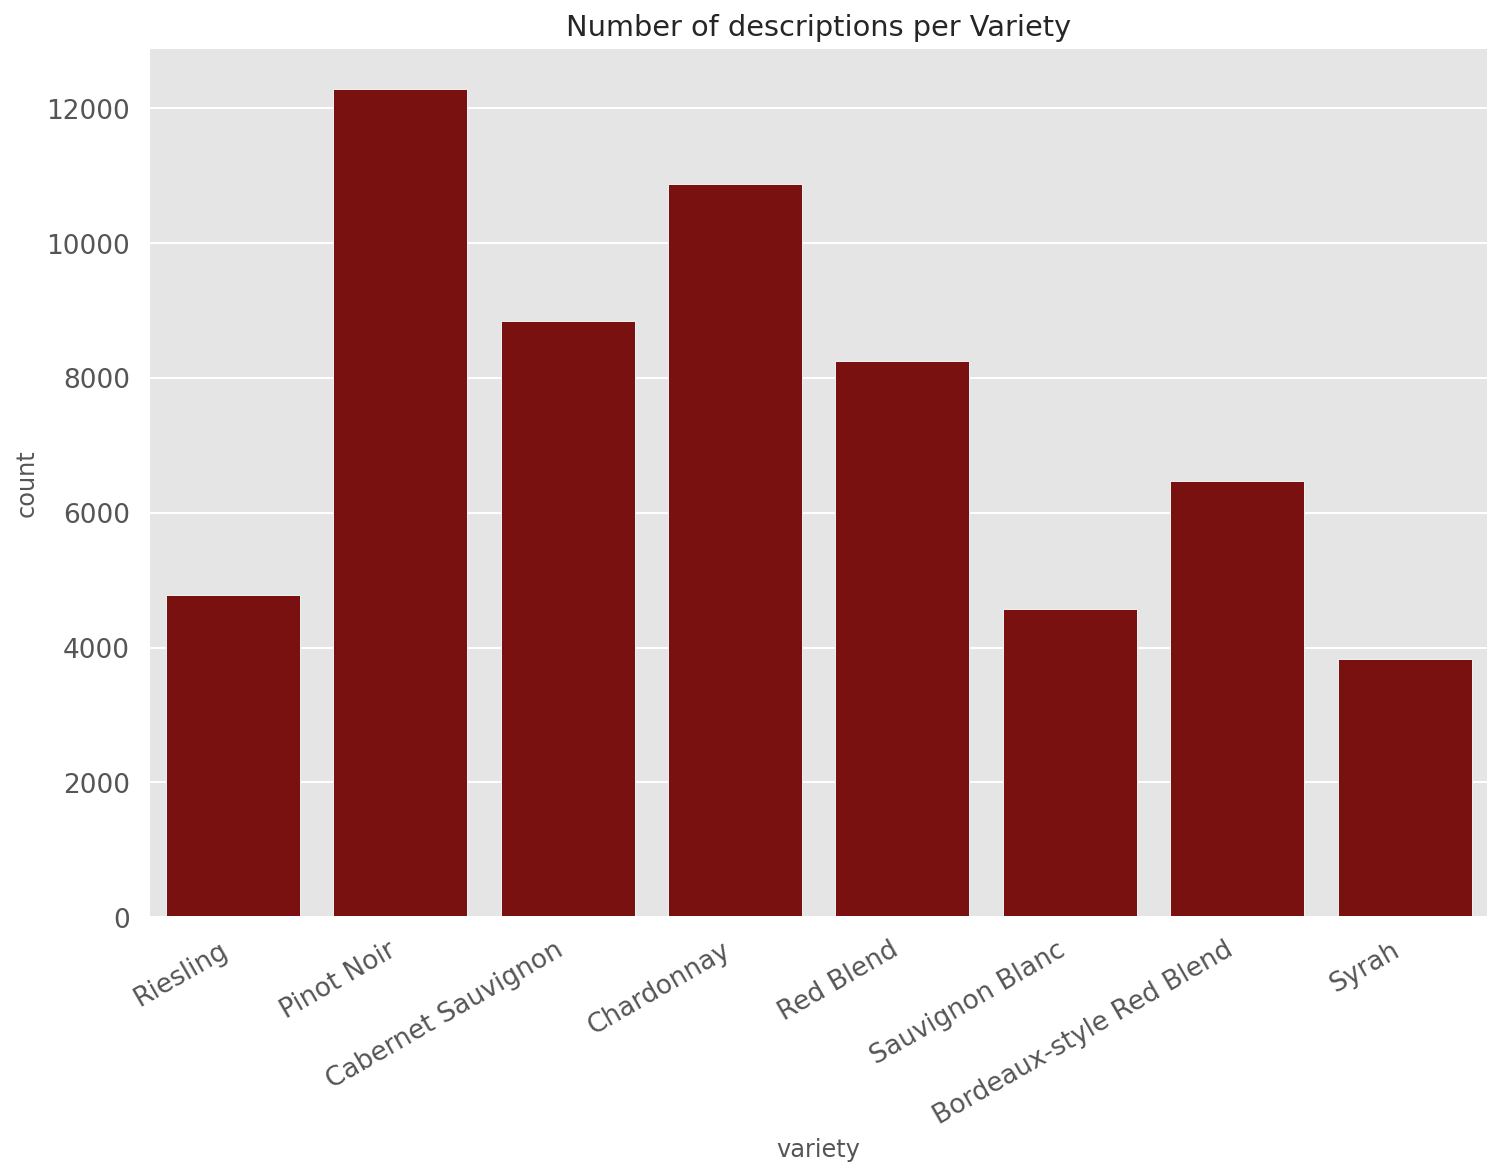

In [57]:
chart = sns.countplot(df.variety, color='darkred')
plt.title("Number of descriptions per Variety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.description, df.variety, test_size = 0.2, random_state = 42)

In [59]:
train = { 'text': X_train, 'intent': y_train }
train_df = pd.DataFrame(train)
test = { 'text': X_test, 'intent': y_test }
test_df = pd.DataFrame(test)

In [60]:
train_df.head()

text  \
123119  The wine is seriously structured for the vinta...   
62381   Most 2006 Chilean Chardonnays are past their p...   
87314   Very dry and tannic, an austere young Cabernet...   
57262   Too soft for comfort, and too sweet, although ...   
93390   This is a structured wine that shows class and...   

                          intent  
123119  Bordeaux-style Red Blend  
62381                 Chardonnay  
87314         Cabernet Sauvignon  
57262         Cabernet Sauvignon  
93390   Bordeaux-style Red Blend

In [61]:
# Making the training dataset uniform - taking the wine with least number of count (i.e. Syrah)
syrah_df = train_df[train_df['intent']=='Syrah']
# Selecting other varities of wines
riesling_df = train_df[train_df['intent']=='Riesling']
pinot_noir_df = train_df[train_df['intent']=='Pinot Noir']
chardonnay_df = train_df[train_df['intent']=='Chardonnay']
cabernet_sauvignon_df = train_df[train_df['intent']=='Cabernet Sauvignon']
red_blend_df = train_df[train_df['intent']=='Red Blend']
bordeaux_style_red_blend_df = train_df[train_df['intent']=='Bordeaux-style Red Blend']
sauvignon_blanc_df = train_df[train_df['intent']=='Sauvignon Blanc']

In [62]:
# Setting their count equal to that of Syrah
pinot_noir_df = pinot_noir_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
chardonnay_df = chardonnay_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
cabernet_sauvignon_df = cabernet_sauvignon_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
red_blend_df = red_blend_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
bordeaux_style_red_blend_df = bordeaux_style_red_blend_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
riesling_df = riesling_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
sauvignon_blanc_df = sauvignon_blanc_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)

In [63]:
# Adding all the data together
syrah_df = syrah_df.append(pinot_noir_df).reset_index(drop=True)
syrah_df = syrah_df.append(chardonnay_df).reset_index(drop=True)
syrah_df = syrah_df.append(cabernet_sauvignon_df).reset_index(drop=True)
syrah_df = syrah_df.append(red_blend_df).reset_index(drop=True)
syrah_df = syrah_df.append(bordeaux_style_red_blend_df).reset_index(drop=True)
syrah_df = syrah_df.append(riesling_df).reset_index(drop=True)
syrah_df = syrah_df.append(sauvignon_blanc_df).reset_index(drop=True)
train_df = syrah_df
train_df.shape

(24368, 2)

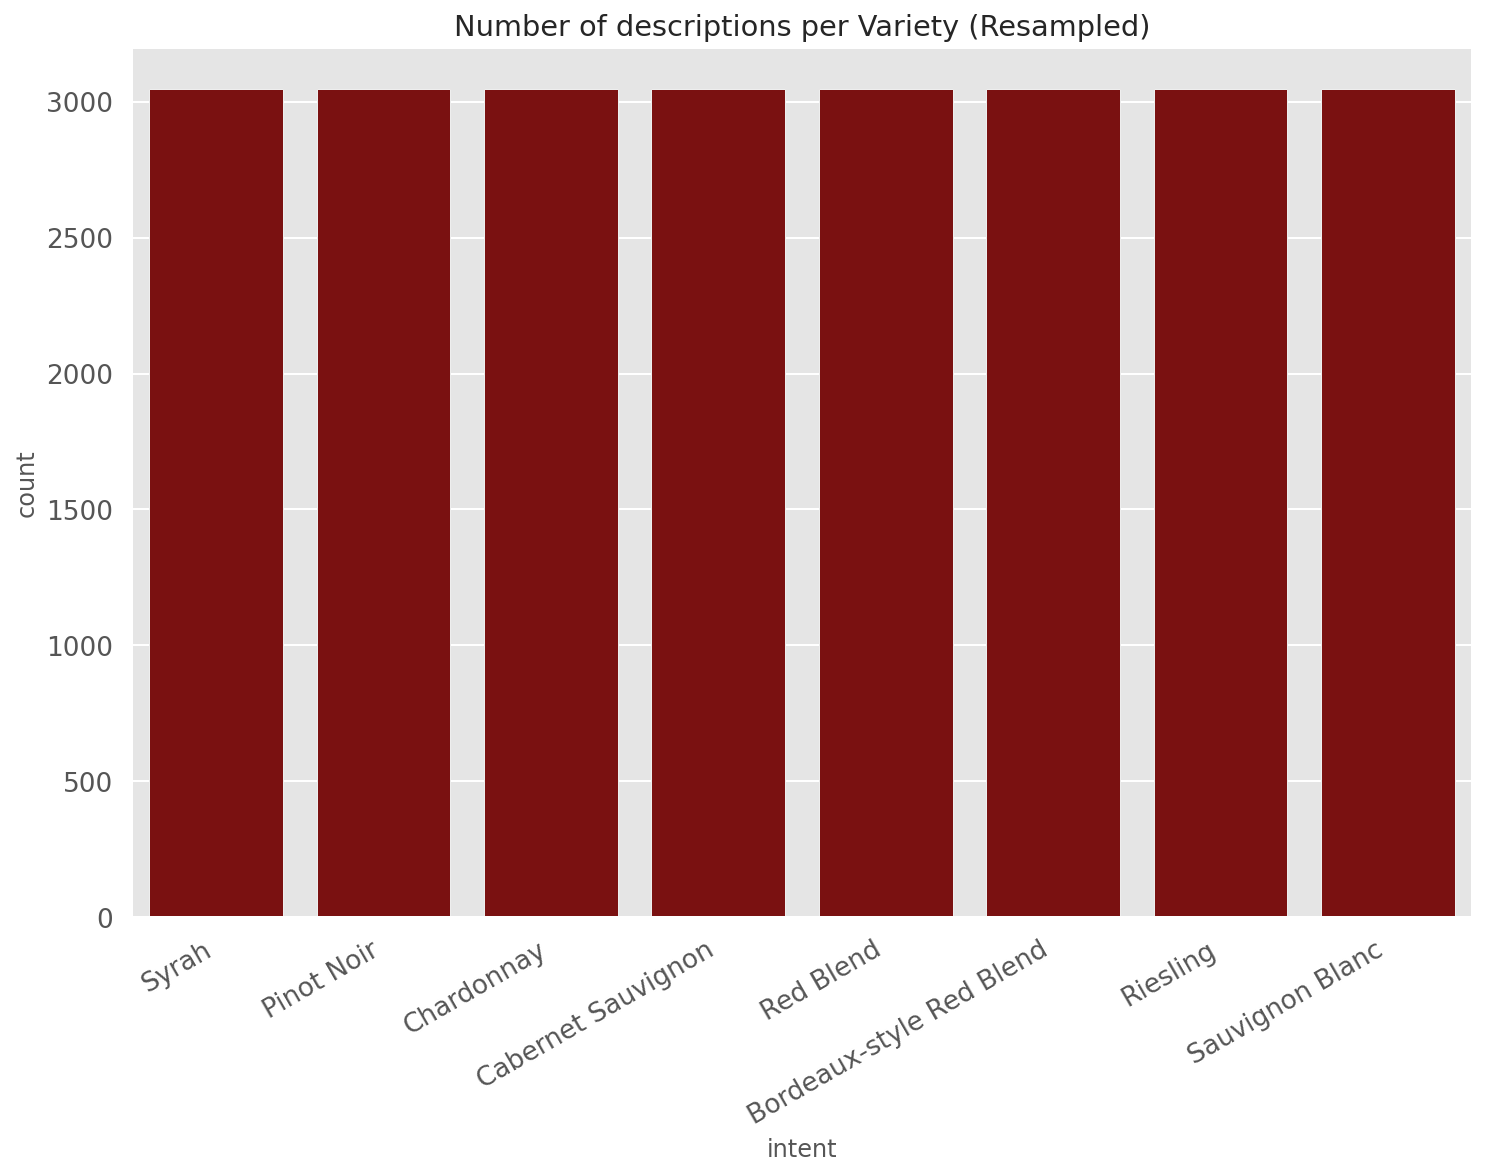

In [64]:
chart = sns.countplot(train_df.intent, color='darkred')
plt.title("Number of descriptions per Variety (Resampled)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [65]:
# Shuffling the data
train_df = train_df.sample(frac=1).reset_index(drop=True)

<a id="section-five"></a>
# 5. BERT

Google’s **BERT** is a NLP framework. **BERT** stands for **Bidirectional Encoder Representations from Transformers**. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

The quest for learning language representations by pre-training models on large unlabelled text data started from word embeddings like **Word2Vec** and **GloVe**. One limitation of these embeddings was the use of very shallow Language Models. This meant there was a limit to the amount of information they could capture and this motivated the use of deeper and more complex language models (layers of **LSTMs** and **GRUs**). Another key limitation was that these models did not take the context of the word into account.

We will use **BERT** to extract embeddings from each review in the dataset and then use these embeddings to train a text classification model

<img src="https://bs-uploads.toptal.io/blackfish-uploads/uploaded_file/file/40127/image-1567089150930-365a40370d26388997f678560fb7eb77.png" width="1000">

In [66]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-05 01:16:11--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 172.253.123.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  41.6MB/s    in 9.3s    

2020-09-05 01:16:20 (41.6 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [67]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [68]:
os.makedirs("model", exist_ok=True)

In [69]:
!mv uncased_L-12_H-768_A-12/ model

In [70]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [71]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes
        train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
    def _prepare(self, df):
        x, y = [], []
        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))
        return np.array(x), np.array(y)
    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [72]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [73]:
tokenizer.tokenize("I like red wine more than white wine")

['i', 'like', 'red', 'wine', 'more', 'than', 'white', 'wine']

In [74]:
tokens = tokenizer.tokenize("Wines from some countries are very underrated!")
tokenizer.convert_tokens_to_ids(tokens)

[14746, 2013, 2070, 3032, 2024, 2200, 2104, 9250, 999]

In [75]:
def create_model(max_seq_len, bert_ckpt_file):
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
    print("bert shape", bert_output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="swish")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_ckpt_file)
    return model

In [76]:
test_df.head()

text           intent
102043  An intriguing wine, with aromas of white peppe...            Syrah
59645   The wine is all about fresh apples and pears, ...       Chardonnay
83445   The allure of ripe but zingy passion fruit pro...  Sauvignon Blanc
73289   Oaky-sweet and simple, with jammy pineapple, t...       Chardonnay
69327   Spicy and dusty smelling, with full-force plum...       Pinot Noir

In [77]:
classes = train_df.intent.unique().tolist()
data = IntentDetectionData(train_df, test_df, tokenizer, classes, max_seq_len=128)

24368it [00:38, 628.59it/s]
11976it [00:18, 659.28it/s]


max seq_len 180


In [78]:
data.train_x.shape

(24368, 128)

In [79]:
data.train_x[0]

array([  101, 10964,  2011,  1046,  2140, 15453, 10179,  7869,  1012,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [80]:
data.train_y[0]

5

In [81]:
data.max_seq_len

128

In [82]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f6c5e681ad0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [83]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

In [84]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [85]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=10,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
1371/1371 [==============================] - 824s 601ms/step - loss: 1.7076 - acc: 0.5689 - val_loss: 1.5125 - val_acc: 0.7571
Epoch 2/10
1371/1371 [==============================] - 821s 598ms/step - loss: 1.5250 - acc: 0.7500 - val_loss: 1.4751 - val_acc: 0.7957
Epoch 3/10
1371/1371 [==============================] - 821s 599ms/step - loss: 1.4885 - acc: 0.7849 - val_loss: 1.4612 - val_acc: 0.8158
Epoch 4/10
1371/1371 [==============================] - 817s 596ms/step - loss: 1.4690 - acc: 0.8046 - val_loss: 1.4676 - val_acc: 0.8039
Epoch 5/10
1371/1371 [==============================] - 818s 597ms/step - loss: 1.4544 - acc: 0.8200 - val_loss: 1.4596 - val_acc: 0.8137
Epoch 6/10
1371/1371 [==============================] - 820s 598ms/step - loss: 1.4452 - acc: 0.8281 - val_loss: 1.4571 - val_acc: 0.8158
Epoch 7/10
1371/1371 [==============================] - 824s 601ms/step - loss: 1.4333 - acc: 0.8405 - val_loss: 1.4489 - val_acc: 0.8240
Epoch 8/10
1371/1371 [============

Text(0.5, 1.0, 'Loss over training epochs')

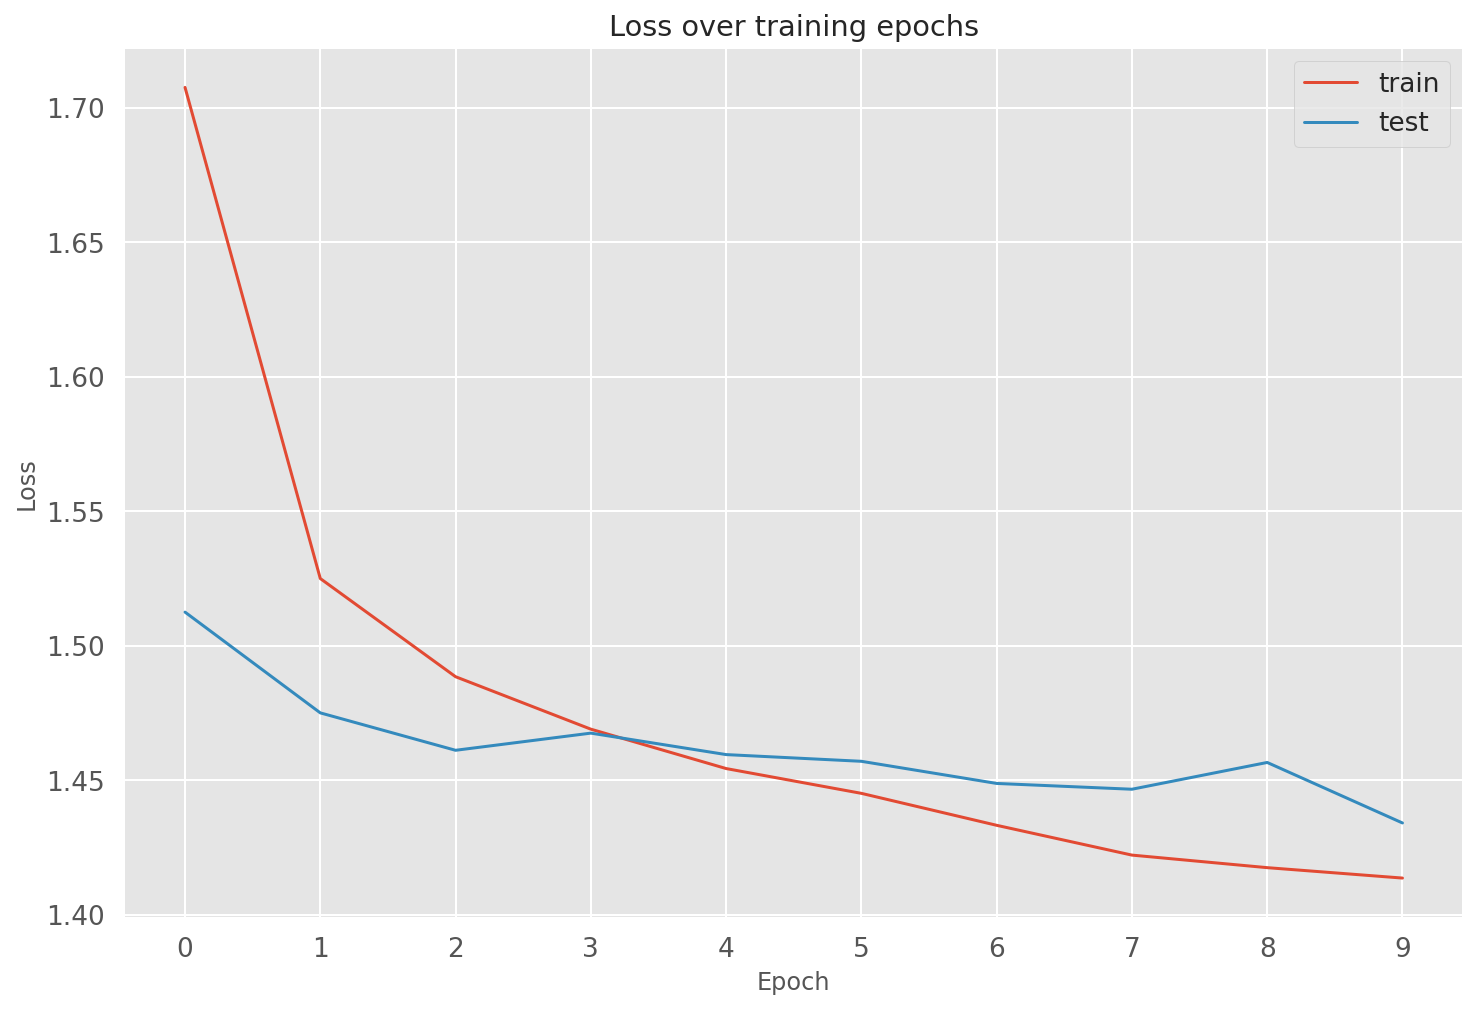

In [86]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')

Text(0.5, 1.0, 'Accuracy over training epochs')

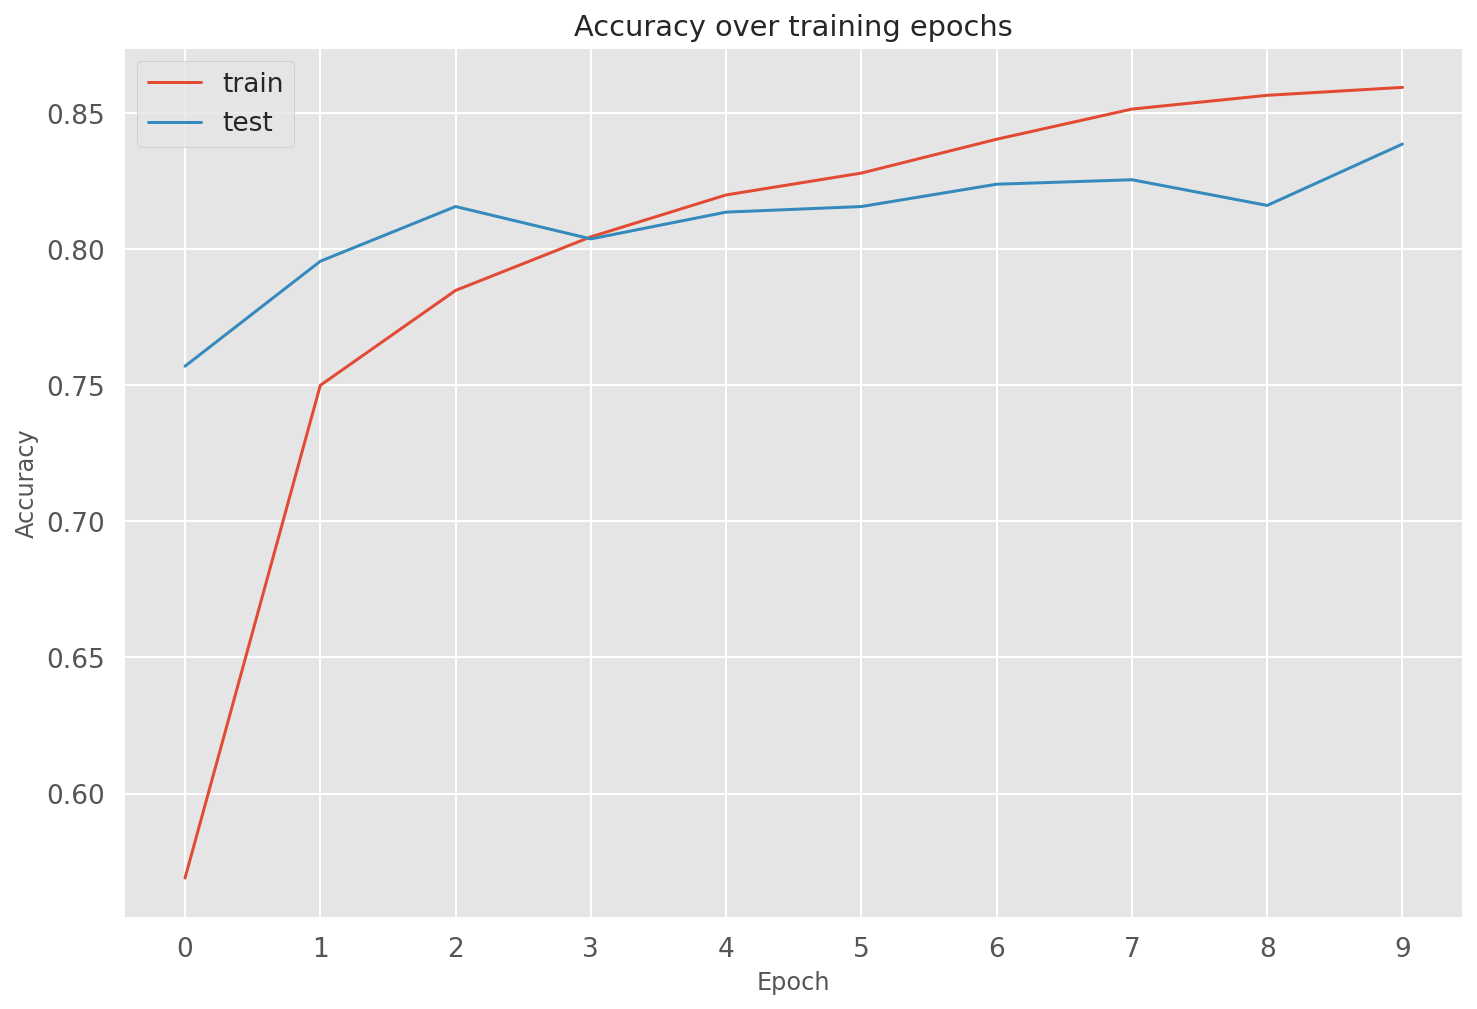

In [87]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')

In [88]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)
print(Fore.RED + "train acc", train_acc)
print(Fore.BLUE + "test acc", test_acc)

375/375 [==============================] - 66s 177ms/step - loss: 1.4652 - acc: 0.8075
train acc 0.8850541710853577
test acc 0.8075317144393921


In [89]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [90]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                          precision    recall  f1-score   support

      Cabernet Sauvignon       0.76      0.73      0.75      1747
                   Syrah       0.55      0.77      0.64       782
                Riesling       0.85      0.91      0.88       927
              Chardonnay       0.92      0.84      0.88      2190
              Pinot Noir       0.87      0.80      0.83      2490
         Sauvignon Blanc       0.73      0.85      0.79       949
Bordeaux-style Red Blend       0.78      0.87      0.82      1279
               Red Blend       0.88      0.74      0.80      1612

                accuracy                           0.81     11976
               macro avg       0.79      0.81      0.80     11976
            weighted avg       0.82      0.81      0.81     11976



In [91]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

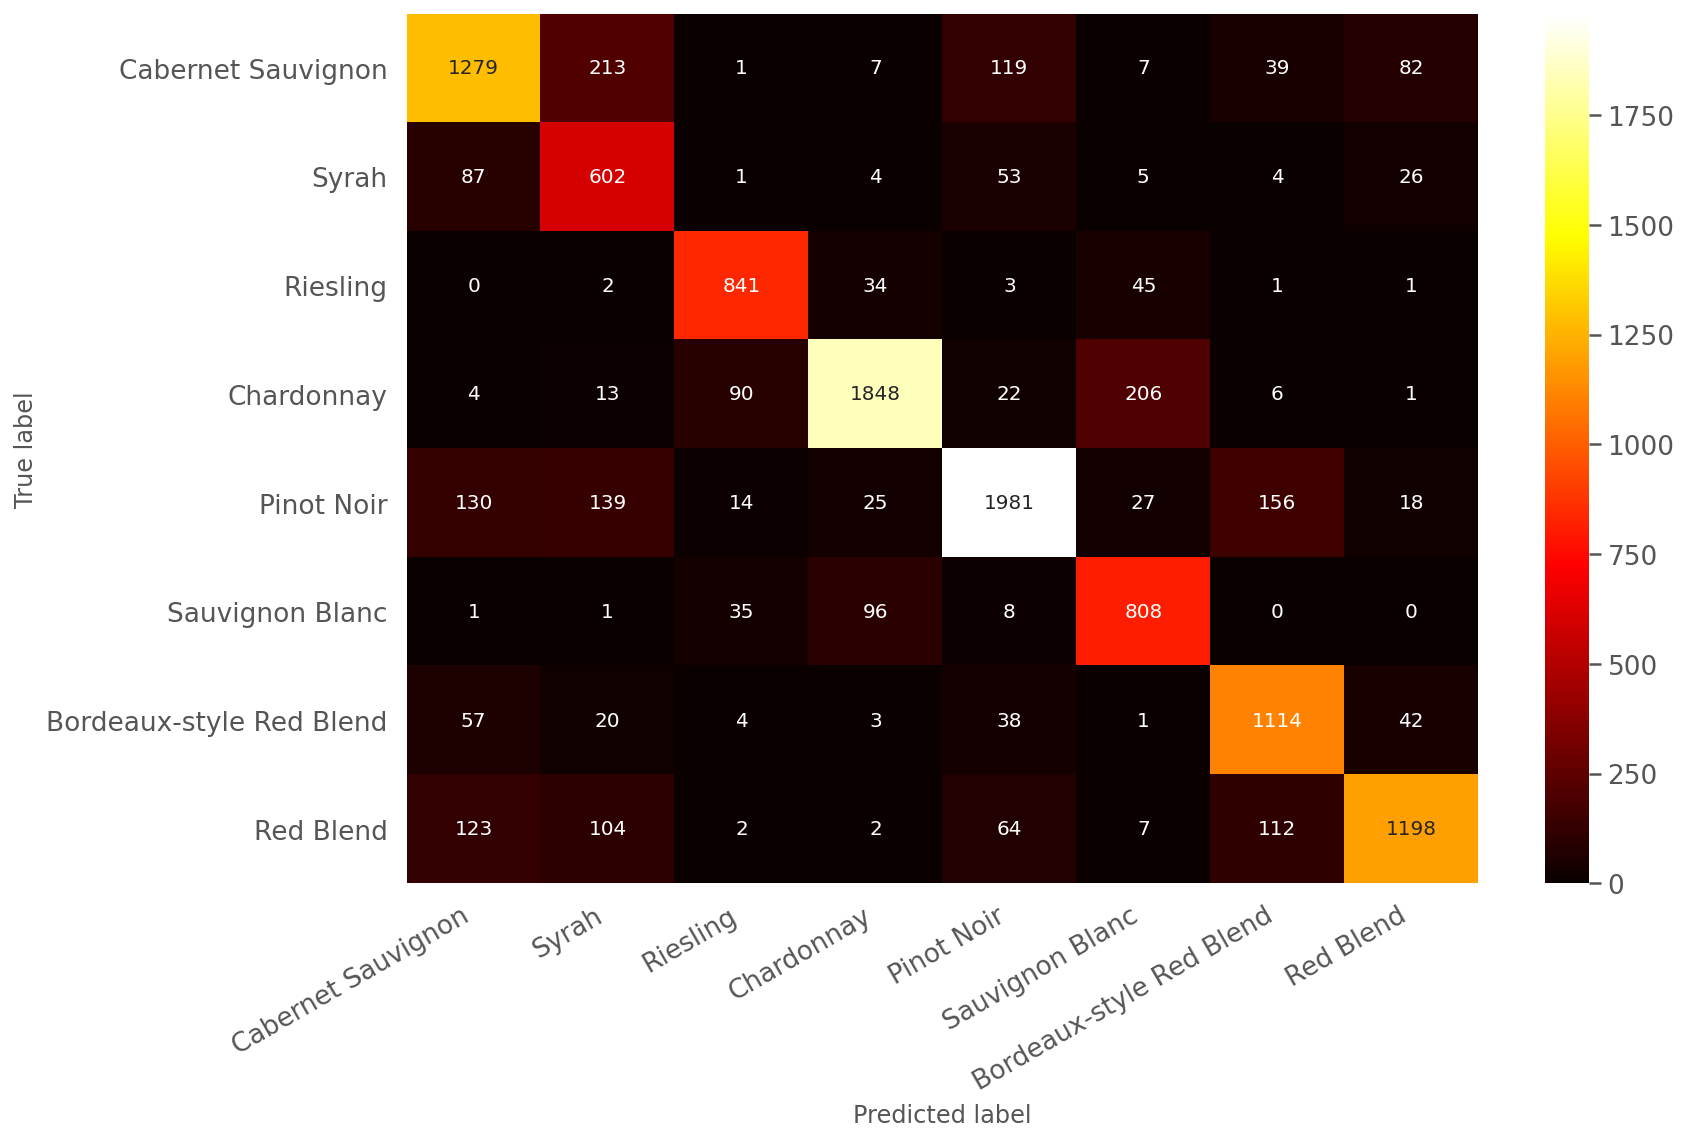

In [92]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='hot')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [93]:
sentences = [
  "Strong wine made of red grapes",
  "Grapy plummy and juicy taste"
]
pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))
predictions = model.predict(pred_token_ids).argmax(axis=-1)
for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: Strong wine made of red grapes 
intent: Bordeaux-style Red Blend

text: Grapy plummy and juicy taste 
intent: Cabernet Sauvignon



**References:**
1. [https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/](http://)
2. https://www.kaggle.com/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn
3. https://www.kaggle.com/kshitijmohan/wine-recommendation-system-based-on-bert
4. https://realpython.com/natural-language-processing-spacy-python/
5. https://www.kaggle.com/sudhirnl7/wine-recommender